In [1]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
##Classe com vários métodos de pre-processamento de texto em português criado pelo grupo F03
import utils.preprocessing_portuguese as preprossPT

In [12]:
df = pd.read_csv("lstm_data/preprocessed_data_v2_2.csv")
df['file_dir']

0       ../data/290-licitacoes-cristais/data/files_jso...
1       ../data/290-licitacoes-cristais/data/files_jso...
2       ../data/290-licitacoes-cristais/data/files_jso...
3       ../data/290-licitacoes-cristais/data/files_jso...
4       ../data/290-licitacoes-cristais/data/files_jso...
                              ...                        
5648    ../data/304-licitacoes-passa-vinte/data/files_...
5649    ../data/304-licitacoes-passa-vinte/data/files_...
5650    ../data/304-licitacoes-passa-vinte/data/files_...
5651    ../data/306-licitacoes-arantina/data/files_jso...
5652    ../data/289-licitacoes-coqueiral/data/files_js...
Name: file_dir, Length: 5653, dtype: object

In [10]:
df = pd.read_csv("lstm_data/preprocessed_data_v2.csv")
df['doc_id'].nunique()

5653

### Faz a leitura de todas as planilhas e armazena em um único dataframe

In [7]:
sheet_names = ['sao-bento-abade', 'olaria', 'coqueiral', 'cristais', 'pirapetinga', 'passa-vinte', 'arantina', 'itamarati', 'ribeirao-vermelho']
file_dir = 'resultado_m03_meta_classes_extraction/resultado_final.xlsx'
all_sheets = []
for sheet in sheet_names:
    df = pd.read_excel(file_dir, sheet_name=sheet)
    df.columns = df.columns.str.lower()
    all_sheets.append(df)
# Concatena todos dataframes em apenas um
df_rotulos = pd.concat(all_sheets)
# Dropa linhas vazias e reseta o indice
#df_rotulos.dropna(how='all', subset=['doc_id', 'title', 'city', 'all_matches', 'meta-class',
#       'real_meta-class', 'real_class', 'key_words', 'obs', 'escaneado'], inplace=True)
df_rotulos.reset_index(drop=True, inplace=True)
df_rotulos.head()

,number,doc_id,title,city,all_matches,meta-class,real_meta-class,real_class,key_words,obs,escaneado
0,0,275acd244d5791013bd8f4b3243a4a1a,prefeitura municipal de são bento abade mg adm...,sao-bento-abade,"['ata', 'ata']",ATA,ATA,ATA DE REGISTRO DE PREÇOS,"ATA, ATA DE REGISTRO DE PREÇOS",NaN,NaN
1,1,2309298b1878b216dca666aba446a4cd,prefeitura municipal de são bento abade mg ...,sao-bento-abade,"['ata', 'sessão pública', 'edital']",ATA,ATA,ATA DE SESSÃO PÚBLICA,"ATA, tomada de preco",NaN,NaN
2,2,85c1a53d38e9f0128f437554523bf87c,prefeitura municipal de são bento abade estado...,sao-bento-abade,"['ata', 'ata', 'homologação', 'homologação', '...",ATA,ATA,ATA REFERENTE A FASE DE JULGAMENTO DAS EMPRESAS,"ATA, FASE DE JULGAMENTO",NaN,NaN
3,3,4d6035bf3212568e336fe0ab7d9fb215,prefeitura municipal de são bento abade estad...,sao-bento-abade,"['ata', 'sessão pública', 'edital']",ATA,ATA,ATA DO PREGÃO PRESENCIAL,"ATA, ATA DO PREGÃO PRESENCIAL",NaN,NaN
4,4,580e6393365c2957e221de56844dd011,prefeitura municipal de são bento abade estado...,sao-bento-abade,"['ata', 'sessão pública', 'edital', 'edital']",ATA,ATA,ATA DO PREGÃO PRESENCIAL,"sessao, publica",NaN,NaN


### Exploração Inicial dos Dados

In [10]:
print("Numero de documentos rotulados: ",df_rotulos.shape[0])

Numero de documentos rotulados:  5298


In [20]:
print("Documentos rotulados por cidade")
display(df_rotulos.groupby("city").size())
print()
print("Numero inicial de classes")
display(df_rotulos['real_class'].nunique())
print()
print("Numero inicial de classes por Municipio")
display(df_rotulos.groupby(["city", "real_class"]).size().reset_index().groupby('city').size())

Documentos rotulados por cidade


city
arantina              328
coqueiral            1494
cristais             1287
itamarati             595
olaria                 36
passa-vinte           369
pirapetinga           788
ribeirao-vermelho     172
sao-bento-abade       229
dtype: int64


Numero inicial de classes


285


Numero inicial de classes por Municipio


city
arantina             16
coqueiral            97
cristais             46
itamarati            34
olaria               12
passa-vinte          41
pirapetinga          89
ribeirao-vermelho    16
sao-bento-abade      28
dtype: int64

### Analise de termos

In [6]:
def limpeza_texto(page_text):
    txt_process = preprossPT.TextPreProcessing()
    
    page_text = page_text.lower()
    
    page_text = txt_process.remove_pronouns(page_text)

    page_text = txt_process.remove_reduced_or_contracted_words(page_text)

    page_text = txt_process.remove_adverbs(page_text)

    page_text = txt_process.remove_special_characters(page_text)

    page_text = txt_process.remove_excessive_spaces(page_text)

    page_text = txt_process.remove_accents(page_text)

    page_text = txt_process.remove_stopwords(page_text)

    page_text = txt_process.remove_symbols_from_numbers(page_text)

    page_text = txt_process.remove_numbers(page_text)

    page_text = txt_process.remove_urls(page_text)
    
    page_text = txt_process.remove_person_names(page_text)
    
    #Removendo letras sozinhas no texto
    page_text = re.sub(r'(?:^| )\w(?:$| )', ' ', page_text).strip()

    page_text = page_text.replace("_","")
    
    return page_text

In [7]:
processed_classes = df_rotulos['real_class'].to_list()
processed_classes = [limpeza_texto(class_name) for class_name in processed_classes]
df_rotulos['processed_classes'] = processed_classes
print("Número real de classes ", len(set(processed_classes)))

Número real de classes  263


In [9]:
terms = []
for class_name in processed_classes:
    terms.extend(class_name.split(" "))
print("Numero de termos ",len(set(terms)))

Numero de termos  237


In [10]:
df_terms = pd.DataFrame(columns=["term", "count"])
df_terms['term'] = Counter(terms).keys()
df_terms['count'] = Counter(terms).values()

df_terms.sort_values(by="count",ascending=False, inplace=True)
df_terms

,term,count
11,edital,2034
12,licitacao,1372
16,contrato,966
0,ata,888
53,administrativo,673
...,...,...
74,administrativos,1
41,plano,1
43,gestao,1
72,re,1


In [11]:
df_processed_classes = pd.DataFrame(columns=["document_class", "count"])
df_processed_classes['document_class'] = Counter(processed_classes).keys()
df_processed_classes['count'] = Counter(processed_classes).values()

df_processed_classes.sort_values(by="count",ascending=False, inplace=True)
df_processed_classes

,document_class,count
4,edital licitacao,1156
41,contrato administrativo,459
0,ata registro precos,346
6,edital pregao presencial,344
40,edital,275
...,...,...
174,aviso convocacao colocado,1
173,aviso decisao proposta,1
172,planilha mao obra,1
171,aviso data divulgacao classificacao proposta,1


### Exploração das classes

In [12]:
df_rotulos.loc[df_rotulos['real_meta-class'].isnull(), 'real_meta-class'] = 'NULL'

In [13]:
df_count_class_and_meta = df_rotulos.groupby(['real_meta-class', 'processed_classes']).size().reset_index(name='count').sort_values(by='count', ascending=False)
df_count_class_and_meta.to_csv('numero_de_classes_rotuladas.csv',index=False)

In [14]:
def explore_class(class_name, df_rotulos):
    print(class_name)
    display(df_rotulos.loc[df_rotulos['processed_classes'] ==class_name].groupby("city").size())
    print(df_rotulos.loc[df_rotulos['processed_classes'] ==class_name, 'city'].unique())
    print(df_rotulos.loc[df_rotulos['processed_classes'] ==class_name, 'city'].nunique())
    print("="*100)

In [15]:
[explore_class(class_name, df_rotulos) for class_name in df_rotulos['processed_classes'].unique()]

ata registro precos


city
coqueiral          253
cristais            27
passa-vinte          1
pirapetinga         58
sao-bento-abade      7
dtype: int64

['sao-bento-abade' 'coqueiral' 'cristais' 'pirapetinga' 'passa-vinte']
5
ata sessao publica


city
passa-vinte         6
sao-bento-abade    14
dtype: int64

['sao-bento-abade' 'passa-vinte']
2
ata referente fase julgamento empresas


city
sao-bento-abade    3
dtype: int64

['sao-bento-abade']
1
ata pregao presencial


city
cristais           116
sao-bento-abade     20
dtype: int64

['sao-bento-abade' 'cristais']
2
edital licitacao


city
arantina           248
coqueiral           16
cristais           562
itamarati           58
passa-vinte        148
pirapetinga          7
sao-bento-abade    117
dtype: int64

['sao-bento-abade' 'coqueiral' 'cristais' 'pirapetinga' 'passa-vinte'
 'arantina' 'itamarati']
7
edital registro precos


city
cristais           1
sao-bento-abade    4
dtype: int64

['sao-bento-abade' 'cristais']
2
edital pregao presencial


city
coqueiral             69
itamarati            121
pirapetinga           70
ribeirao-vermelho     80
sao-bento-abade        4
dtype: int64

['sao-bento-abade' 'coqueiral' 'pirapetinga' 'itamarati'
 'ribeirao-vermelho']
5
termo homologacao


city
sao-bento-abade    1
dtype: int64

['sao-bento-abade']
1
homologacao adjudicacao


city
itamarati          44
sao-bento-abade     1
dtype: int64

['sao-bento-abade' 'itamarati']
2
contrato


city
coqueiral           7
itamarati          17
pirapetinga         4
sao-bento-abade     6
dtype: int64

['sao-bento-abade' 'coqueiral' 'pirapetinga' 'itamarati']
4
aviso remarcacao licitacao


city
sao-bento-abade    4
dtype: int64

['sao-bento-abade']
1
adendo edital


city
cristais            6
sao-bento-abade    16
dtype: int64

['sao-bento-abade' 'cristais']
2
termo ratificacao


city
coqueiral          1
passa-vinte        1
sao-bento-abade    5
dtype: int64

['sao-bento-abade' 'coqueiral' 'passa-vinte']
3
aviso licitacao


city
cristais            2
itamarati           2
pirapetinga        90
sao-bento-abade     1
dtype: int64

['sao-bento-abade' 'cristais' 'pirapetinga' 'itamarati']
4
aviso anulacao


city
sao-bento-abade    1
dtype: int64

['sao-bento-abade']
1
anexo


city
coqueiral          1
sao-bento-abade    2
dtype: int64

['sao-bento-abade' 'coqueiral']
2
tutorial


city
arantina            1
passa-vinte        23
sao-bento-abade     1
dtype: int64

['sao-bento-abade' 'passa-vinte' 'arantina']
3
aviso suspensao


city
cristais           1
olaria             2
pirapetinga        2
sao-bento-abade    5
dtype: int64

['sao-bento-abade' 'olaria' 'cristais' 'pirapetinga']
4
edital chamada publica


city
arantina           11
cristais            1
itamarati          16
passa-vinte         2
sao-bento-abade     4
dtype: int64

['sao-bento-abade' 'cristais' 'passa-vinte' 'arantina' 'itamarati']
5
edital credenciamento


city
arantina             5
coqueiral            2
itamarati            2
ribeirao-vermelho    2
sao-bento-abade      3
dtype: int64

['sao-bento-abade' 'coqueiral' 'arantina' 'itamarati' 'ribeirao-vermelho']
5
errata


city
arantina              2
cristais             10
itamarati             2
passa-vinte           2
ribeirao-vermelho     2
sao-bento-abade       1
dtype: int64

['sao-bento-abade' 'cristais' 'passa-vinte' 'arantina' 'itamarati'
 'ribeirao-vermelho']
6
aviso impugnacao


city
sao-bento-abade    2
dtype: int64

['sao-bento-abade']
1
processo seletivo


city
coqueiral          10
cristais            3
sao-bento-abade     1
dtype: int64

['sao-bento-abade' 'coqueiral' 'cristais']
3
revogacao edital


city
olaria             1
sao-bento-abade    1
dtype: int64

['sao-bento-abade' 'olaria']
2
mail


city
cristais           2
sao-bento-abade    1
dtype: int64

['sao-bento-abade' 'cristais']
2
ata recebimento


city
sao-bento-abade    2
dtype: int64

['sao-bento-abade']
1
adjudicacao   homologacao


city
itamarati          1
passa-vinte        7
sao-bento-abade    1
dtype: int64

['sao-bento-abade' 'passa-vinte' 'itamarati']
3
ata


city
coqueiral          35
cristais            5
sao-bento-abade     1
dtype: int64

['sao-bento-abade' 'coqueiral' 'cristais']
3
retificacao edital


city
coqueiral    11
cristais      6
itamarati     2
olaria       16
dtype: int64

['olaria' 'coqueiral' 'cristais' 'itamarati']
4
projeto


city
olaria    2
dtype: int64

['olaria']
1
resposta esclarecimento


city
arantina       2
olaria         7
passa-vinte    2
dtype: int64

['olaria' 'passa-vinte' 'arantina']
3
cronograma financeiro


city
olaria    1
dtype: int64

['olaria']
1
plano municipal gestao


city
olaria    1
dtype: int64

['olaria']
1
identificavel


city
cristais    2
olaria      1
dtype: int64

['olaria' 'cristais']
2
planilha levantamento quantidades


city
olaria    1
dtype: int64

['olaria']
1
cronograma


city
olaria    1
dtype: int64

['olaria']
1
levantamento planimetrico


city
olaria    2
dtype: int64

['olaria']
1
planilha orcamentaria


city
olaria         1
pirapetinga    4
dtype: int64

['olaria' 'pirapetinga']
2
ata pregao srp


city
coqueiral    4
cristais     3
dtype: int64

['coqueiral' 'cristais']
2
alteracao valor ata


city
coqueiral    1
dtype: int64

['coqueiral']
1
edital


city
arantina              19
coqueiral            189
itamarati             15
passa-vinte            1
pirapetinga            1
ribeirao-vermelho     50
dtype: int64

['coqueiral' 'pirapetinga' 'passa-vinte' 'arantina' 'itamarati'
 'ribeirao-vermelho']
6
contrato administrativo


city
coqueiral      451
pirapetinga      8
dtype: int64

['coqueiral' 'pirapetinga']
2
aditamento contrato administrativo


city
coqueiral    157
dtype: int64

['coqueiral']
1
aditamento contrato administrativo   ata


city
coqueiral    51
dtype: int64

['coqueiral']
1
extrato contrato


city
coqueiral       2
cristais       25
passa-vinte     3
pirapetinga     4
dtype: int64

['coqueiral' 'cristais' 'pirapetinga' 'passa-vinte']
4
termo apoio emergencial


city
coqueiral    12
dtype: int64

['coqueiral']
1
distrato contrato administrativo


city
coqueiral    3
dtype: int64

['coqueiral']
1
revogacao


city
coqueiral    1
dtype: int64

['coqueiral']
1
resposta impugnacao apresentada


city
coqueiral    6
dtype: int64

['coqueiral']
1
pedido impugnacao


city
coqueiral            2
ribeirao-vermelho    1
dtype: int64

['coqueiral' 'ribeirao-vermelho']
2
ata avaliacao propostas


city
coqueiral    1
dtype: int64

['coqueiral']
1
minuta ata registro precos


city
coqueiral    1
dtype: int64

['coqueiral']
1
ordem servico


city
coqueiral    1
dtype: int64

['coqueiral']
1
resposta recurso inabilitacao


city
coqueiral    1
dtype: int64

['coqueiral']
1
resposta impugnacao edital


city
coqueiral    10
dtype: int64

['coqueiral']
1
edital chamamento publico


city
coqueiral            8
ribeirao-vermelho    1
dtype: int64

['coqueiral' 'ribeirao-vermelho']
2
minuta contrato administrativo


city
coqueiral    2
dtype: int64

['coqueiral']
1
outros


city
arantina     1
coqueiral    2
dtype: int64

['coqueiral' 'arantina']
2
termo colaboracao


city
coqueiral    1
dtype: int64

['coqueiral']
1
re retificacao edital


city
coqueiral    1
dtype: int64

['coqueiral']
1
resposta recursos administrativos


city
coqueiral    1
dtype: int64

['coqueiral']
1
minuta aditamento contrato administrativo   ata


city
coqueiral    1
dtype: int64

['coqueiral']
1
resposta questionamento


city
coqueiral    3
dtype: int64

['coqueiral']
1
errata edital


city
coqueiral    9
dtype: int64

['coqueiral']
1
memorial descritivo


city
coqueiral       7
pirapetinga    13
dtype: int64

['coqueiral' 'pirapetinga']
2
declaracao acessibilidade


city
coqueiral    2
dtype: int64

['coqueiral']
1
decisao impugnacao


city
coqueiral    1
dtype: int64

['coqueiral']
1
projeto arquitetonico


city
coqueiral      13
pirapetinga    21
dtype: int64

['coqueiral' 'pirapetinga']
2
declaracao dmt


city
coqueiral    1
dtype: int64

['coqueiral']
1
composicao bdi


city
coqueiral      4
pirapetinga    6
dtype: int64

['coqueiral' 'pirapetinga']
2
cronograma fisico financeiro


city
coqueiral      6
pirapetinga    9
dtype: int64

['coqueiral' 'pirapetinga']
2
ordem servico obra


city
coqueiral    13
dtype: int64

['coqueiral']
1
planilha orcamentaria custos


city
coqueiral    4
dtype: int64

['coqueiral']
1
questionamento


city
coqueiral    1
dtype: int64

['coqueiral']
1
termo fomento


city
coqueiral    1
dtype: int64

['coqueiral']
1
cotacao preco medio


city
coqueiral    3
dtype: int64

['coqueiral']
1
memoria calculo


city
coqueiral      3
pirapetinga    9
dtype: int64

['coqueiral' 'pirapetinga']
2
grafico distribuicao valores   item


city
coqueiral    2
dtype: int64

['coqueiral']
1
custos totais   item


city
coqueiral    1
dtype: int64

['coqueiral']
1
grafico demonstrativo servicos


city
coqueiral    1
dtype: int64

['coqueiral']
1
resposta pedido reconsideracao recurso


city
coqueiral    1
dtype: int64

['coqueiral']
1
aviso retificacao item


city
coqueiral    1
dtype: int64

['coqueiral']
1
aviso retificacao edital


city
coqueiral    5
dtype: int64

['coqueiral']
1
contrato adesao diario oficial


city
coqueiral    1
dtype: int64

['coqueiral']
1
justificativa julgamento item


city
coqueiral    1
dtype: int64

['coqueiral']
1
contrato fornecimento bens


city
coqueiral    9
dtype: int64

['coqueiral']
1
aditamento contrato prestacao servicos


city
coqueiral    2
dtype: int64

['coqueiral']
1
termo revogacao certame


city
coqueiral    3
dtype: int64

['coqueiral']
1
distrato ata registro precos


city
coqueiral    1
dtype: int64

['coqueiral']
1
contrato servicos


city
coqueiral    5
dtype: int64

['coqueiral']
1
impugnacao edital


city
coqueiral    1
dtype: int64

['coqueiral']
1
resposta recurso


city
coqueiral    2
dtype: int64

['coqueiral']
1
cotacao


city
coqueiral    1
dtype: int64

['coqueiral']
1
instrucoes uso   sistema web


city
coqueiral    1
dtype: int64

['coqueiral']
1
errada edital


city
coqueiral    1
dtype: int64

['coqueiral']
1
aviso retificacao


city
coqueiral    5
dtype: int64

['coqueiral']
1
termo aditamento contrato


city
coqueiral    4
dtype: int64

['coqueiral']
1
planilha precos


city
coqueiral    1
dtype: int64

['coqueiral']
1
aditamento termo colaboracao


city
coqueiral    1
dtype: int64

['coqueiral']
1
edital tomada precos


city
coqueiral             3
pirapetinga          12
ribeirao-vermelho    14
dtype: int64

['coqueiral' 'pirapetinga' 'ribeirao-vermelho']
3
extrato publicacao


city
coqueiral    2
itamarati    1
dtype: int64

['coqueiral' 'itamarati']
2
extrato contratos


city
coqueiral    14
dtype: int64

['coqueiral']
1
extrato edital


city
coqueiral    3
dtype: int64

['coqueiral']
1
cancelamento licitacao


city
coqueiral    1
dtype: int64

['coqueiral']
1
aviso chamamento publico


city
coqueiral    21
cristais      2
dtype: int64

['coqueiral' 'cristais']
2
extrato edital leilao


city
coqueiral    2
dtype: int64

['coqueiral']
1
comunicado   realizaco audiencia publica


city
coqueiral    1
dtype: int64

['coqueiral']
1
extrato edital pregao presencial


city
coqueiral    1
dtype: int64

['coqueiral']
1
edital leilao publico


city
coqueiral    2
dtype: int64

['coqueiral']
1
resultado processo seletivo


city
coqueiral    1
cristais     2
dtype: int64

['coqueiral' 'cristais']
2
termo ratificacao anulacao


city
coqueiral    1
dtype: int64

['coqueiral']
1
edital concurso publico


city
coqueiral    1
cristais     7
dtype: int64

['coqueiral' 'cristais']
2
gabarito processo seletivo


city
coqueiral    1
dtype: int64

['coqueiral']
1
ratificacao


city
coqueiral       1
passa-vinte     9
pirapetinga    46
dtype: int64

['coqueiral' 'pirapetinga' 'passa-vinte']
3
convite


city
coqueiral    1
dtype: int64

['coqueiral']
1
extrato ata sessao


city
coqueiral    1
dtype: int64

['coqueiral']
1
relacao candidato   vaga retificado


city
coqueiral    1
dtype: int64

['coqueiral']
1
aviso retificacao processo licitatorio


city
coqueiral    1
dtype: int64

['coqueiral']
1
ata dispensa


city
cristais    177
dtype: int64

['cristais']
1
ata sessao abetura licitacao


city
cristais       9
pirapetinga    1
dtype: int64

['cristais' 'pirapetinga']
2
ata julgamento recursos


city
cristais    2
dtype: int64

['cristais']
1
homologacao


city
cristais        2
pirapetinga    56
dtype: int64

['cristais' 'pirapetinga']
2
gasto homologado


city
cristais    126
dtype: int64

['cristais']
1
extrato ata


city
cristais       52
passa-vinte     4
dtype: int64

['cristais' 'passa-vinte']
2
publicacao diario oficial


city
cristais        4
passa-vinte    70
dtype: int64

['cristais' 'passa-vinte']
2
termo referencia


city
cristais    18
dtype: int64

['cristais']
1
retificacao edital pregao presencial


city
cristais     1
itamarati    1
dtype: int64

['cristais' 'itamarati']
2
parecer juridico


city
cristais             2
ribeirao-vermelho    1
dtype: int64

['cristais' 'ribeirao-vermelho']
2
extrato   titulo


city
cristais    4
dtype: int64

['cristais']
1
despacho


city
cristais    4
dtype: int64

['cristais']
1
ata chamada publica


city
cristais    1
dtype: int64

['cristais']
1
ata pregao


city
cristais    1
dtype: int64

['cristais']
1
ata reuniao pregao presencial


city
cristais     3
itamarati    1
dtype: int64

['cristais' 'itamarati']
2
ata julgamento


city
cristais       2
pirapetinga    3
dtype: int64

['cristais' 'pirapetinga']
2
ata inexigibilidade licitacao


city
cristais    8
dtype: int64

['cristais']
1
extrato diario oficial


city
cristais       76
passa-vinte     5
dtype: int64

['cristais' 'passa-vinte']
2
ata habilitacao   julgamento


city
cristais    1
dtype: int64

['cristais']
1
ata cancelamento


city
cristais    1
dtype: int64

['cristais']
1
resultado licitacao


city
cristais    1
dtype: int64

['cristais']
1
solicitacao judicial


city
cristais    1
dtype: int64

['cristais']
1
adendo edital   errata


city
cristais    1
dtype: int64

['cristais']
1
relacao inscritos


city
cristais    1
dtype: int64

['cristais']
1
extrato termo aditivo


city
cristais    4
dtype: int64

['cristais']
1
rol licitantes


city
cristais    2
dtype: int64

['cristais']
1
ata deserto


city
pirapetinga    4
dtype: int64

['pirapetinga']
1
adjudicacao


city
passa-vinte     5
pirapetinga    56
dtype: int64

['pirapetinga' 'passa-vinte']
2
homologacao   adjudicacao


city
pirapetinga    2
dtype: int64

['pirapetinga']
1
relato fotografico


city
pirapetinga    7
dtype: int64

['pirapetinga']
1
contrato compra


city
pirapetinga    11
dtype: int64

['pirapetinga']
1
termo aditivo contrato


city
pirapetinga    103
dtype: int64

['pirapetinga']
1
aviso republicacao


city
pirapetinga    6
dtype: int64

['pirapetinga']
1
ato ratificacao dispensa licitacao


city
pirapetinga    13
dtype: int64

['pirapetinga']
1
nota empenho


city
pirapetinga    12
dtype: int64

['pirapetinga']
1
termo distrato


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
aviso licitacao   minuta edital


city
pirapetinga    2
dtype: int64

['pirapetinga']
1
itens vencidos   fornecedor


city
pirapetinga    3
dtype: int64

['pirapetinga']
1
convocacao   abertura habilitacao


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
chamada publica


city
pirapetinga    6
dtype: int64

['pirapetinga']
1
ato ratificacao inexigibilidade licitacao


city
pirapetinga    4
dtype: int64

['pirapetinga']
1
contrato prestacao servicos


city
pirapetinga    12
dtype: int64

['pirapetinga']
1
planilha custos mao obra


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
planilha custos


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
termo contrato prestacao servicos


city
pirapetinga    7
dtype: int64

['pirapetinga']
1
parecer tecnico


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
aviso reabertura   continuacao licitacao


city
pirapetinga    3
dtype: int64

['pirapetinga']
1
aviso decisao habilitacao


city
pirapetinga    2
dtype: int64

['pirapetinga']
1
termo contrato compra


city
pirapetinga    36
dtype: int64

['pirapetinga']
1
aviso suspensao pregao


city
pirapetinga    5
dtype: int64

['pirapetinga']
1
pedido esclarecimento


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
edital compra


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
ato revogacao licitacao


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
aviso data   divulgacao classificacao proposta


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
planilha mao obra


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
aviso decisao proposta


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
aviso convocacao colocado


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
aviso sorteio


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
aviso resultado sorteio desempate


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
aviso decisao classificacao proposta


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
aviso abertura proposta


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
aviso interposicao recurso


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
aviso data   divulgacao habilitacao


city
pirapetinga    3
dtype: int64

['pirapetinga']
1
termo contrato


city
pirapetinga    5
dtype: int64

['pirapetinga']
1
parecer departamento juridico


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
aviso licitacao   edital


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
contrato concessao uso


city
pirapetinga    3
dtype: int64

['pirapetinga']
1
nao identificavel


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
chamamento   abertura habilitacao


city
pirapetinga    2
dtype: int64

['pirapetinga']
1
planilha custos insumos


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
contrato aquisicao generos alimenticios agricultura familiar   alimentacao escolar


city
pirapetinga    11
dtype: int64

['pirapetinga']
1
aviso concessao prazo   nova habilitacao


city
pirapetinga    2
dtype: int64

['pirapetinga']
1
aviso convocacao


city
passa-vinte    1
pirapetinga    4
dtype: int64

['pirapetinga' 'passa-vinte']
2
planilha preco


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
aviso abertura prazo   oferecimento contrarazoes


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
chamamento   continuacao trabalhos relativos processo licitatorio


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
aviso julgamento habilitacao


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
aviso julgamento propostas


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
relacao ruas   prestacao servicos publicos limpeza


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
publicacao convocacao   assinatura contrato


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
ato anulacao licitacao


city
pirapetinga    2
dtype: int64

['pirapetinga']
1
ata proposta preco


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
aviso reabertura   prosseguimento licitacao


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
edital pregao eletronico


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
contrado compra


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
produtos graficos


city
pirapetinga    4
dtype: int64

['pirapetinga']
1
termo recisao contrato


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
projeto construcao


city
pirapetinga    1
dtype: int64

['pirapetinga']
1
protocolo recebimento edital carta convite


city
passa-vinte    3
dtype: int64

['passa-vinte']
1
recibo retirada edital


city
passa-vinte    8
dtype: int64

['passa-vinte']
1
proposta digital   impressa


city
passa-vinte    26
dtype: int64

['passa-vinte']
1
diario municipal


city
passa-vinte    9
dtype: int64

['passa-vinte']
1
nota fiscal


city
passa-vinte    1
dtype: int64

['passa-vinte']
1
mapa rota transporte escolar


city
passa-vinte    4
dtype: int64

['passa-vinte']
1
termo aditivo   aviso impugnacao


city
passa-vinte    1
dtype: int64

['passa-vinte']
1
ratificacao   extrato contrato


city
passa-vinte    4
dtype: int64

['passa-vinte']
1
ratificacao termo aditivo   extrato contrato


city
passa-vinte    1
dtype: int64

['passa-vinte']
1
revogacao edital   extrato ata


city
passa-vinte    1
dtype: int64

['passa-vinte']
1
termo aditivo


city
passa-vinte    8
dtype: int64

['passa-vinte']
1
ratificacao   aviso convocacao


city
passa-vinte    1
dtype: int64

['passa-vinte']
1
termo aditivo aviso licitacao   extrato ata


city
passa-vinte    1
dtype: int64

['passa-vinte']
1
extrato contrato   errata


city
passa-vinte    1
dtype: int64

['passa-vinte']
1
ratificacao aviso convocacao   extrato ata


city
passa-vinte    1
dtype: int64

['passa-vinte']
1
errata aviso suspensao   extrato ata


city
passa-vinte    1
dtype: int64

['passa-vinte']
1
termo aditivo extrato contrato   adjudicacao


city
passa-vinte    1
dtype: int64

['passa-vinte']
1
termo aditivo ratificacao   adjudicacao


city
passa-vinte    1
dtype: int64

['passa-vinte']
1
extrato contrato   extrato ata


city
passa-vinte    1
dtype: int64

['passa-vinte']
1
ratificacao extrato contrato   termo reequilibrio


city
passa-vinte    1
dtype: int64

['passa-vinte']
1
aviso cancelamento


city
itamarati      6
passa-vinte    1
dtype: int64

['passa-vinte' 'itamarati']
2
dispensa licitacao


city
passa-vinte    1
dtype: int64

['passa-vinte']
1
extrato contrato   ordem servico


city
passa-vinte    1
dtype: int64

['passa-vinte']
1
adjudicacao homologacao   extrato


city
itamarati      1
passa-vinte    1
dtype: int64

['passa-vinte' 'itamarati']
2
auxilio transporte


city
arantina    1
dtype: int64

['arantina']
1
folha pagamento


city
arantina    32
dtype: int64

['arantina']
1
evolucao folha


city
arantina    1
dtype: int64

['arantina']
1
cargos vagos ocupados


city
arantina    1
dtype: int64

['arantina']
1
lista bens moveis


city
arantina    1
dtype: int64

['arantina']
1
folha admitidos


city
arantina    1
dtype: int64

['arantina']
1
custo   secretaria


city
arantina    1
dtype: int64

['arantina']
1
relatorio vacancia


city
arantina    1
dtype: int64

['arantina']
1
edital retificado


city
itamarati    5
dtype: int64

['itamarati']
1
carta convite


city
itamarati    10
dtype: int64

['itamarati']
1
edital credenciamento publico


city
itamarati    1
dtype: int64

['itamarati']
1
homologacao adjudicacao extrato


city
itamarati    119
dtype: int64

['itamarati']
1
aviso licitacao edital tomada precos


city
itamarati    2
dtype: int64

['itamarati']
1
homologacao termo adjudicacao extrato


city
itamarati    63
dtype: int64

['itamarati']
1
ratificacao dispensa licitacao


city
itamarati    66
dtype: int64

['itamarati']
1
ratificacao inexigibilidade


city
itamarati    4
dtype: int64

['itamarati']
1
aviso adiamento


city
itamarati    1
dtype: int64

['itamarati']
1
edital ratificado


city
itamarati    1
dtype: int64

['itamarati']
1
edital leilao


city
itamarati    1
dtype: int64

['itamarati']
1
aviso deserto


city
itamarati    1
dtype: int64

['itamarati']
1
edital pregao


city
itamarati    3
dtype: int64

['itamarati']
1
edital concorrencia publica


city
itamarati             1
ribeirao-vermelho    10
dtype: int64

['itamarati' 'ribeirao-vermelho']
2
recibo edital pregao presencial


city
itamarati    20
dtype: int64

['itamarati']
1
recibo edital chamada publica


city
itamarati    1
dtype: int64

['itamarati']
1
certidao processo licitatorio deserto


city
itamarati    2
dtype: int64

['itamarati']
1
adjudicacao homologacao contrato


city
itamarati    4
dtype: int64

['itamarati']
1
redesignacao sessao processo licitatorio


city
ribeirao-vermelho    1
dtype: int64

['ribeirao-vermelho']
1
registro fornecedores   precos cotados


city
ribeirao-vermelho    2
dtype: int64

['ribeirao-vermelho']
1
edital pregao presencial registro precos


city
ribeirao-vermelho    1
dtype: int64

['ribeirao-vermelho']
1
decisao administrativa


city
ribeirao-vermelho    1
dtype: int64

['ribeirao-vermelho']
1
adiamento


city
ribeirao-vermelho    1
dtype: int64

['ribeirao-vermelho']
1
planilha   declaracao orcamento


city
ribeirao-vermelho    3
dtype: int64

['ribeirao-vermelho']
1
comunicado


city
ribeirao-vermelho    2
dtype: int64

['ribeirao-vermelho']
1


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [293]:
class_name = 'aviso licitacao'
explore_class(class_name, df_rotulos)

aviso licitacao


city
cristais            2
itamarati           2
pirapetinga        90
sao-bento-abade     1
dtype: int64

['sao-bento-abade' 'cristais' 'pirapetinga' 'itamarati']
4


In [294]:
df_rotulos.loc[df_rotulos['processed_classes'] == class_name]

,number,doc_id,title,city,all_matches,meta-class,real_meta-class,real_class,key_words,obs,escaneado,processed_classes
33,33,41bb83c74f0429de1086ebcf63901d14,cnpj 17 877 176 0001 29 fone 0 35 3236 121...,sao-bento-abade,[],OUTROS,OUTROS,AVISO DE LICITAÇÃO,AVISO,NaN,NaN,aviso licitacao
1864,105,e2b96ec39104508596819b3452daebe4,diário oficial do município aviso de licitaçã...,cristais,"['diário oficial', 'aviso de']",OUTROS,OUTROS,AVISO DE LICITAÇÃO,NaN,No título aparece diário oficial do municipio,NaN,aviso licitacao
1871,112,60723b287fd2094a9a65d6460309eeb4,diário oficial do município aviso de licitaçã...,cristais,"['diário oficial', 'aviso de']",OUTROS,OUTROS,AVISO DE LICITAÇÃO,NaN,No título aparece diário oficial do municipio,NaN,aviso licitacao
3091,45,ea278081883087bf32fd33184e921171,prefeitura municipal de pirapetinga cep 36 73...,pirapetinga,"['edital', 'edital', 'aviso de']",OUTROS,OUTROS,AVISO DE LICITAÇÃO,"AVISO, LICITACAO",NaN,NaN,aviso licitacao
3096,50,4fb9cac8a18f49a2f1b857bc95e14353,prefeitura municipal de pirapetinga cep 36 73...,pirapetinga,"['edital', 'edital', 'aviso de']",OUTROS,OUTROS,AVISO DE LICITAÇÃO,"AVISO, LICITACAO",NaN,NaN,aviso licitacao
...,...,...,...,...,...,...,...,...,...,...,...,...
3774,728,a1ca2ada69ef0dbe413472136a5e835d,prefeitura municipal de pirapetinga cep 36 73...,pirapetinga,"['edital', 'edital', 'aviso de']",OUTROS,OUTROS,AVISO DE LICITACAO,NaN,NaN,NaN,aviso licitacao
3778,732,d83e6e4d1524aa3190c6f42a8541fd78,prefeitura municipal de pirapetinga cep 36 73...,pirapetinga,"['edital', 'edital', 'aviso de']",OUTROS,OUTROS,AVISO DE LICITACAO,NaN,NaN,NaN,aviso licitacao
3828,782,205b1a16685c51eaf85358f2ae1a489a,prefeitura municipal de pirapetinga cep 36 73...,pirapetinga,"['edital', 'edital', 'aviso de']",OUTROS,OUTROS,AVISO DE LICITACAO,NaN,NaN,NaN,aviso licitacao
4676,145,064896ebd0519676fef30c0912b2c7e6,prefeitura municipal de itamarati de minas e...,itamarati,"['sessão pública', 'edital', 'edital', 'edital']",EDITAL,OUTROS,AVISO DE LICITAÇÃO,NaN,NaN,NaN,aviso licitacao


In [21]:
df_rotulos.loc[(df_rotulos['processed_classes'] == class_name) & (df_rotulos['real_meta-class'] != 'HOMOLOG')]

,number,doc_id,title,city,all_matches,meta-class,real_meta-class,real_class,key_words,obs,escaneado,processed_classes
1923,164,c8cc587ca217d520a9065b4109a06a5e,prefeitura municipal de cristais praça cel jo...,cristais,"['ata', 'sessão pública', 'edital', 'edital']",ATA,ATA,ATA DE CHAMADA PÚBLICA,NaN,NaN,NaN,ata chamada publica


In [50]:
class_name = 'ata sessao abetura licitacao'
explore_class(class_name, df_rotulos)

ata sessao abetura licitacao


city
cristais       9
pirapetinga    1
dtype: int64

['cristais' 'pirapetinga']
2


In [51]:
df_rotulos.loc[df_rotulos['processed_classes'] == class_name]

,number,doc_id,title,city,all_matches,meta-class,real_meta-class,real_class,key_words,obs,escaneado,processed_classes
1760,1,2cb3f9bdfa78bee9de9937c2a8c42174,prefeitura municipal de cristais praça cel jo...,cristais,"['ata', 'sessão pública']",ATA,ATA,ATA DE SESSÃO DE ABETURA DE LICITAÇÃO,NaN,NaN,NaN,ata sessao abetura licitacao
1761,2,f1287cc8fcccf899d0b5d7446381eb34,ata do pregão presencial n 017 2017 aos 09 03...,cristais,"['ata', 'sessão pública']",ATA,ATA,ATA DE SESSÃO DE ABETURA DE LICITAÇÃO,NaN,NaN,NaN,ata sessao abetura licitacao
1765,6,b811b453d6ce70cb0bfc588161b96dd2,ata do pregão presencial n 24 2017 aos 04 04 ...,cristais,"['ata', 'sessão pública', 'edital']",ATA,ATA,ATA DE SESSÃO DE ABETURA DE LICITAÇÃO,NaN,NaN,NaN,ata sessao abetura licitacao
1766,7,6dd12515afd2ccf77deb66e2d96d4da9,prefeitura municipal de cristais praça cel jo...,cristais,"['ata', 'sessão pública']",ATA,ATA,ATA DE SESSÃO DE ABETURA DE LICITAÇÃO,NaN,NaN,NaN,ata sessao abetura licitacao
1767,8,67dfdf460e020cbafa3d5dcb42153132,ata do pregão presencial n 00040 2015 aos 18 ...,cristais,"['ata', 'sessão pública', 'edital']",ATA,ATA,ATA DE SESSÃO DE ABETURA DE LICITAÇÃO,NaN,NaN,NaN,ata sessao abetura licitacao
1769,10,5a1d3235d4893a0e166fc87b4f30de5b,prefeitura municipal de cristais praça cel jo...,cristais,"['ata', 'sessão pública', 'edital']",ATA,ATA,ATA DE SESSÃO DE ABETURA DE LICITAÇÃO,NaN,NaN,NaN,ata sessao abetura licitacao
1770,11,1a0df92c6a295bd4ea4776a4e61c9bc8,ata do pregão presencial n 033 2015 aos 23 06...,cristais,"['ata', 'ata', 'sessão pública', 'homologação'...",ATA,ATA,ATA DE SESSÃO DE ABETURA DE LICITAÇÃO,envelopes,NaN,NaN,ata sessao abetura licitacao
1771,12,dbd06aba9f943c1dfda6dd3e05f283ee,ata do pregão presencial n 00036 2015 aos 30 ...,cristais,"['ata', 'ata', 'sessão pública']",ATA,ATA,ATA DE SESSÃO DE ABETURA DE LICITAÇÃO,NaN,NaN,NaN,ata sessao abetura licitacao
1772,13,94cbb7c0710eda204d32940b26503796,ata do pregão presencial n 00058 2017 aos 27 ...,cristais,"['ata', 'sessão pública']",ATA,ATA,ATA DE SESSÃO DE ABETURA DE LICITAÇÃO,NaN,NaN,NaN,ata sessao abetura licitacao
3052,6,88819c18e27860449b0162bef68d4a68,prefeitura municipal de pirapetinga cep 36 73...,pirapetinga,"['ata', 'ata', 'homologação', 'adjudicação', '...",ATA,ATA,ATA DE SESSÃO DE ABETURA DE LICITAÇÃO,NaN,NaN,NaN,ata sessao abetura licitacao


In [ ]:
import argparse
import re
import subprocess

import pandas as pd
import psutil
import requests
import tabulate

kernel_regex = re.compile(r".+kernel-(.+)\.json")
notebook_regex = re.compile(r"(https?://([^:/]+):?(\d+)?)/?(\?token=([a-z0-9]+))?")


def get_proc_info():
    pids = psutil.pids()

    # memory info from psutil.Process
    df_mem = []

    for pid in pids:
        try:
            proc = psutil.Process(pid)
            cmd = " ".join(proc.cmdline())
        except psutil.NoSuchProcess:
            continue

        if len(cmd) > 0 and ("jupyter" in cmd or "ipython" in cmd) and "kernel" in cmd:
            # kernel
            kernel_ID = re.sub(kernel_regex, r"\1", cmd)

            # memory
            mem = proc.memory_info()[0] / float(1e9)

            uname = proc.username()

            # user, pid, memory, kernel_ID
            df_mem.append([uname, pid, mem, kernel_ID])

    df_mem = pd.DataFrame(df_mem)
    df_mem.columns = ["user", "pid", "memory_GB", "kernel_ID"]
    return df_mem


def get_running_notebooks():
    notebooks = []

    for n in subprocess.Popen(
        ["jupyter", "notebook", "list"], stdout=subprocess.PIPE
    ).stdout.readlines()[1:]:
        match = re.match(notebook_regex, n.decode())
        if match:
            base_url, host, port, _, token = match.groups()
            notebooks.append({"base_url": base_url, "token": token})
        else:
            print("Unknown format: {}".format(n.decode()))

    return notebooks


def get_session_info(password=None):
    df_nb = []
    kernels = []

    for notebook in get_running_notebooks():
        s = requests.Session()
        if notebook["token"] is not None:
            s.get(notebook["base_url"] + "/?token=" + notebook["token"])
        else:
            # do a get to the base url to get the session cookies
            s.get(notebook["base_url"])
        if password is not None:
            # Seems jupyter auth process has changed, need to first get a cookie,
            # then add that cookie to the data being sent over with the password
            data = {"password": password}
            data.update(s.cookies)
            s.post(notebook["base_url"] + "/login", data=data)

        res = s.get(notebook["base_url"] + "/api/sessions")

        if res.status_code != 200:
            raise Exception(res.json())

        for sess in res.json():
            kernel_ID = sess["kernel"]["id"]
            if kernel_ID not in kernels:
                kernel = {
                    "kernel_ID": kernel_ID,
                    "kernel_name": sess["kernel"]["name"],
                    "kernel_state": sess["kernel"]["execution_state"],
                    "kernel_connections": sess["kernel"]["connections"],
                    # "notebook_url": notebook["base_url"] + "/notebook/" + sess["id"],
                    "notebook_path": sess["path"],
                }
                kernel.update(notebook)
                df_nb.append(kernel)
                kernels.append(kernel_ID)

    df_nb = pd.DataFrame(df_nb)
    del df_nb["token"]
    return df_nb


def parse_args():
    parser = argparse.ArgumentParser(description="Find memory usage.")
    parser.add_argument("--password", help="password (only needed if pass-protected)")

    return parser.parse_args()


def main(password=None, print_ascii=False):
    df_mem = get_proc_info()
    df_nb = get_session_info(password)

    # joining tables
    df = pd.merge(df_nb, df_mem, on=["kernel_ID"], how="inner")
    df = df.sort_values("memory_GB", ascending=False).reset_index(drop=True)
    if print_ascii:
        print(tabulate.tabulate(df, headers=(df.columns.tolist())))
    return df


if __name__ == "__main__":
    #args = vars(parse_args())
    main(None, print_ascii=True)

# Julgamento

In [4]:
import pandas as pd
import glob

In [26]:
for file in glob.glob('../data/dados_abertos/licitacao_2021/3100104/*.csv'):
    df = pd.read_csv(file, sep=";")
    for col in df.columns:
        if "num_doc" in col:
            print(file)
            print(col)

../data/dados_abertos/licitacao_2021/3100104/2021.3100104.licitacao.parecLicitacao.csv
num_doc_resp_parecer
../data/dados_abertos/licitacao_2021/3100104/2021.3100104.licitacao.respDispensa.csv
num_doc_responsavel
../data/dados_abertos/licitacao_2021/3100104/2021.3100104.licitacao.respLicitacao.csv
num_documento
../data/dados_abertos/licitacao_2021/3100104/2021.3100104.licitacao.comissaoLicitacao.csv
num_documento
../data/dados_abertos/licitacao_2021/3100104/2021.3100104.licitacao.fornDispensa.csv
num_doc_fornecedor
../data/dados_abertos/licitacao_2021/3100104/2021.3100104.licitacao.habLicitacao.csv
num_documento
../data/dados_abertos/licitacao_2021/3100104/2021.3100104.licitacao.quadroSocLicitacao.csv
num_documento
../data/dados_abertos/licitacao_2021/3100104/2021.3100104.licitacao.homologLicitacao.csv
num_doc_vencedor
../data/dados_abertos/licitacao_2021/3100104/2021.3100104.licitacao.credDispensa.csv
num_doc_credenciado
../data/dados_abertos/licitacao_2021/3100104/2021.3100104.licita

In [23]:
df = pd.read_csv("../data/dados_abertos/licitacao_2021/3100104/2021.3100104.licitacao.homologLicitacao.csv", sep=";")
df

,seq_hom_licitacao,seq_licitacao,seq_item_licitacao,seq_orgao,num_ano_referencia,num_mes_referencia,num_quant_item,vlr_unitario,vlr_pct_desconto,vlr_pct_tax_adm,vlr_global,num_doc_vencedor,nom_vencedor,num_versao_arq


In [22]:
glob.glob('../data/dados_abertos/licitacao_2021/3100104/*.csv')

['../data/dados_abertos/licitacao_2021/3100104/2021.3100104.licitacao.parecLicitacao.csv',
 '../data/dados_abertos/licitacao_2021/3100104/2021.3100104.licitacao.recDispensa.csv',
 '../data/dados_abertos/licitacao_2021/3100104/2021.3100104.licitacao.respDispensa.csv',
 '../data/dados_abertos/licitacao_2021/3100104/2021.3100104.licitacao.respLicitacao.csv',
 '../data/dados_abertos/licitacao_2021/3100104/2021.3100104.licitacao.cotRegadesao.csv',
 '../data/dados_abertos/licitacao_2021/3100104/2021.3100104.licitacao.comissaoLicitacao.csv',
 '../data/dados_abertos/licitacao_2021/3100104/2021.3100104.licitacao.itemDispensa.csv',
 '../data/dados_abertos/licitacao_2021/3100104/2021.3100104.licitacao.fornDispensa.csv',
 '../data/dados_abertos/licitacao_2021/3100104/2021.3100104.licitacao.recLicitacao.csv',
 '../data/dados_abertos/licitacao_2021/3100104/2021.3100104.licitacao.habLicitacao.csv',
 '../data/dados_abertos/licitacao_2021/3100104/2021.3100104.licitacao.quadroSocLicitacao.csv',
 '../dat

# LSTM data prep

In [2]:
from collections import Counter
from functools import partial
import copy

import numpy as np
import os
import pandas as pd
import random
from sklearn.metrics import f1_score, accuracy_score
import spacy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

SEED = 42

In [30]:
df_data = pd.read_csv("./lstm_data/preprocessed_data_v2.csv")
df_data.head()

,doc_id,final_meta-class,label,label_int,city,file_dir,one_page,two_pages,three_pages,four_pages,fold,four_pages_processed
0,499fa518c7724a6e449c509b7d7bc819,ATA,ata dispensa licitacao,0,cristais,../data/290-licitacoes-cristais/data/files_jso...,comissao permanente licitacoes ata dispensa ju...,comissao permanente licitacoes ata dispensa ju...,comissao permanente licitacoes ata dispensa ju...,comissao permanente licitacoes ata dispensa ju...,val,comissao permanente licitacoes ata dispensa ju...
1,56a09c5d1d04cc95ada4d68ad22dcbd9,ATA,ata dispensa licitacao,0,cristais,../data/290-licitacoes-cristais/data/files_jso...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,test,comissao permanente licitacoes dia fevereiro r...
2,6e9f35208290c1130fcccad47b50aa53,ATA,ata dispensa licitacao,0,cristais,../data/290-licitacoes-cristais/data/files_jso...,praca cel centro estado cep pabx cnpj comissa...,praca cel centro estado cep pabx cnpj comissa...,praca cel centro estado cep pabx cnpj comissa...,praca cel centro estado cep pabx cnpj comissa...,val,praca cel centro estado cep pabx cnpj comissao...
3,669c029c5812ec9a31b9c211044157b4,ATA,ata dispensa licitacao,0,cristais,../data/290-licitacoes-cristais/data/files_jso...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,val,comissao permanente licitacoes dia fevereiro r...
4,a22421dc45d623c9200c7e8fb1e6ca34,ATA,ata dispensa licitacao,0,cristais,../data/290-licitacoes-cristais/data/files_jso...,comissao permanente licitacoes maio reuniu com...,comissao permanente licitacoes maio reuniu com...,comissao permanente licitacoes maio reuniu com...,comissao permanente licitacoes maio reuniu com...,train,comissao permanente licitacoes maio reuniu com...


In [31]:
(df_data.groupby("fold").size()/df_data.shape[0]).reset_index(name="size")

,fold,size
0,test,0.099947
1,train,0.699982
2,val,0.200071


In [32]:
pd.pivot_table((df_data.groupby(["fold", "label"]).size()/df_data.groupby("fold").size()).reset_index(name="size"), values=["size"],  columns=["fold"], index=["label"])*100

size                      
fold                            test      train        val
label                                                     
aditamento                  5.663717   5.736669   5.747126
ata dispensa licitacao      3.185841   3.209502   3.183024
ata pregao presencial       2.654867   2.704069   2.740937
ata registro precos         6.194690   6.242103   6.189213
aviso                       5.663717   5.534496   5.570292
contrato                   10.265487  10.260298  10.256410
edital                     39.292035  39.221633  39.168877
errata                      1.946903   1.895375   1.856764
homologacao adjudicacao     6.725664   6.696993   6.719717
outras atas                 1.592920   1.516300   1.503095
outros                     10.973451  11.043720  11.052166
publicacao diario oficial   3.185841   3.234774   3.271441
ratificacao                 2.654867   2.704069   2.740937

In [33]:
df_data.groupby(["label_int", "label"]).size().reset_index()

,label_int,label,0
0,0,ata dispensa licitacao,181
1,1,outras atas,86
2,2,ata pregao presencial,153
3,3,ata registro precos,352
4,4,edital,2217
5,5,homologacao adjudicacao,379
6,6,errata,107
7,7,aditamento,324
8,8,outros,624
9,9,aviso,314


In [34]:
df_data.drop_duplicates(subset=["city", "label"]).groupby(["city"]).size().reset_index()

,city,0
0,arantina,3
1,coqueiral,9
2,cristais,10
3,ijaci,6
4,itamarati,8
5,olaria,4
6,passa_vinte,7
7,pirapetinga,9
8,ribeirao_vermelho,4
9,sao_bento_abade,10


In [35]:
df_data.groupby("city").size()

city
arantina              328
coqueiral            1481
cristais             1287
ijaci                 398
itamarati             595
olaria                 28
passa_vinte           369
pirapetinga           766
ribeirao_vermelho     172
sao_bento_abade       229
dtype: int64

In [21]:
df_data.loc[~df_data["city"].isin(["pirapetinga", "sao_bento_abade"])].groupby(["label_int","label"]).size()

label_int  label                    
0          ata dispensa licitacao        181
1          ata julgamento                  3
2          ata pregao presencial         132
3          ata registro precos           287
4          ata sessao publica              6
5          outras atas                    49
6          edital                       1983
7          adjudicacao                     5
8          homologacao                    18
9          homologacao adjudicacao       239
10         errata                         90
11         aditamento                    221
12         outros                        164
13         aviso                         168
14         contrato                      476
15         decisao/impugnacao             43
16         publicacao diario oficial     183
17         extrato                       122
18         planilhas                     157
19         memorial                       10
20         outros termos                  36
21         ratific

In [1]:
import pandas as pd

In [2]:
df_data = pd.read_csv("./lstm_data/preprocessed_data_v2_2.csv")
df_data.head()

,doc_id,final_meta-class,label,label_int,city,file_dir,one_page,two_pages,three_pages,four_pages,fold,four_pages_processed
0,499fa518c7724a6e449c509b7d7bc819,ATA,ata dispensa licitacao,0,cristais,../data/290-licitacoes-cristais/data/files_jso...,comissao permanente licitacoes ata dispensa ju...,comissao permanente licitacoes ata dispensa ju...,comissao permanente licitacoes ata dispensa ju...,comissao permanente licitacoes ata dispensa ju...,train,comissao permanente licitacoes ata dispensa ju...
1,56a09c5d1d04cc95ada4d68ad22dcbd9,ATA,ata dispensa licitacao,0,cristais,../data/290-licitacoes-cristais/data/files_jso...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,train,comissao permanente licitacoes dia fevereiro r...
2,6e9f35208290c1130fcccad47b50aa53,ATA,ata dispensa licitacao,0,cristais,../data/290-licitacoes-cristais/data/files_jso...,praca cel centro estado cep pabx cnpj comissa...,praca cel centro estado cep pabx cnpj comissa...,praca cel centro estado cep pabx cnpj comissa...,praca cel centro estado cep pabx cnpj comissa...,train,praca cel centro estado cep pabx cnpj comissao...
3,669c029c5812ec9a31b9c211044157b4,ATA,ata dispensa licitacao,0,cristais,../data/290-licitacoes-cristais/data/files_jso...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,train,comissao permanente licitacoes dia fevereiro r...
4,a22421dc45d623c9200c7e8fb1e6ca34,ATA,ata dispensa licitacao,0,cristais,../data/290-licitacoes-cristais/data/files_jso...,comissao permanente licitacoes maio reuniu com...,comissao permanente licitacoes maio reuniu com...,comissao permanente licitacoes maio reuniu com...,comissao permanente licitacoes maio reuniu com...,train,comissao permanente licitacoes maio reuniu com...


In [3]:
df[["label_int", "label"]].drop_duplicates().to_csv("./lstm_data/results/labels_dict.csv",index=False)

In [4]:
df.loc[~df["city"].isin(["pirapetinga", "sao_bento_abade"])].groupby(["label_int","label"]).size()

label_int  label                    
0          ata dispensa licitacao        181
1          outras atas                    58
2          ata pregao presencial         132
3          ata registro precos           287
4          edital                       1983
5          homologacao adjudicacao       262
6          errata                         90
7          aditamento                    221
8          outros                        532
9          aviso                         168
10         contrato                      476
11         publicacao diario oficial     183
12         ratificacao                    85
dtype: int64

In [5]:
df.loc[df['fold'] == "val"].groupby(["label_int","label"]).size()

label_int  label                  
1          outras atas                  9
3          ata registro precos         58
4          edital                     101
5          homologacao adjudicacao    114
7          aditamento                 103
8          outros                      85
9          aviso                      135
10         contrato                    98
12         ratificacao                 63
dtype: int64

In [6]:
df.loc[df['fold'] == "train", "label"].nunique()

13

In [7]:
df.loc[(df['city']=="pirapetinga") & (df['label'].isin(["aditamento","edital"]))]

,doc_id,final_meta-class,label,label_int,city,file_dir,one_page,two_pages,three_pages,four_pages,fold,four_pages_processed
1467,48de864931f8104786dd9fc1efc6ad92,EDITAL,edital,4,pirapetinga,../data/288-licitacoes-pirapetinga/data/files_...,cep estado departamento licitacoes compras ed...,cep estado departamento licitacoes compras ed...,cep estado departamento licitacoes compras ed...,cep estado departamento licitacoes compras ed...,val,cep estado departamento licitacoes compras edi...
1468,2d8350ef604fccc106b8a164a9da0f11,EDITAL,edital,4,pirapetinga,../data/288-licitacoes-pirapetinga/data/files_...,cep estado departamento licitacoes compras ed...,cep estado departamento licitacoes compras ed...,cep estado departamento licitacoes compras ed...,cep estado departamento licitacoes compras ed...,val,cep estado departamento licitacoes compras edi...
1469,8ee5ce451568d6f8f6d3d510147d940c,EDITAL,edital,4,pirapetinga,../data/288-licitacoes-pirapetinga/data/files_...,cep estado departamento licitacoes compras ed...,cep estado departamento licitacoes compras ed...,cep estado departamento licitacoes compras ed...,cep estado departamento licitacoes compras ed...,val,cep estado departamento licitacoes compras edi...
1470,f9b498137795c6fb3f3e13cb88cec26d,EDITAL,edital,4,pirapetinga,../data/288-licitacoes-pirapetinga/data/files_...,cep estado departamento licitacoes compras ed...,cep estado departamento licitacoes compras ed...,cep estado departamento licitacoes compras ed...,cep estado departamento licitacoes compras ed...,val,cep estado departamento licitacoes compras edi...
1471,a7057777c44e9e7b85f4bbadb1c2edf0,EDITAL,edital,4,pirapetinga,../data/288-licitacoes-pirapetinga/data/files_...,cep estado departamento licitacoes compras ed...,cep estado departamento licitacoes compras ed...,cep estado departamento licitacoes compras ed...,cep estado departamento licitacoes compras ed...,val,cep estado departamento licitacoes compras edi...
...,...,...,...,...,...,...,...,...,...,...,...,...
5535,18b422521388074f96bc0e93cbe24790,OUTROS,aditamento,7,pirapetinga,../data/288-licitacoes-pirapetinga/data/files_...,cep estado termo aditivo contrato processo li...,cep estado termo aditivo contrato processo li...,cep estado termo aditivo contrato processo li...,cep estado termo aditivo contrato processo li...,val,cep estado termo aditivo contrato processo lic...
5536,2b4f47a3c036b61fcbfa5ab2f63a9add,OUTROS,aditamento,7,pirapetinga,../data/288-licitacoes-pirapetinga/data/files_...,cep estado termo aditivo contrato processo in...,cep estado termo aditivo contrato processo in...,cep estado termo aditivo contrato processo in...,cep estado termo aditivo contrato processo in...,val,cep estado termo aditivo contrato processo ine...
5537,57513c11e64a8faf9ab10db7ef599cf2,OUTROS,aditamento,7,pirapetinga,../data/288-licitacoes-pirapetinga/data/files_...,cep estado termo aditivo contrato processo ce...,cep estado termo aditivo contrato processo ce...,cep estado termo aditivo contrato processo ce...,cep estado termo aditivo contrato processo ce...,val,cep estado termo aditivo contrato processo cel...
5538,0b1204ae17ab0437e3c0756461456d89,OUTROS,aditamento,7,pirapetinga,../data/288-licitacoes-pirapetinga/data/files_...,cep estado termo aditivo contrato processo ce...,cep estado termo aditivo contrato processo ce...,cep estado termo aditivo contrato processo ce...,cep estado termo aditivo contrato processo ce...,val,cep estado termo aditivo contrato processo cel...


In [8]:
df.loc[(df['city']=="pirapetinga") & (df['label'].isin(["aditamento",]))]

,doc_id,final_meta-class,label,label_int,city,file_dir,one_page,two_pages,three_pages,four_pages,fold,four_pages_processed
5437,2cd4d24a8087d350570f331482b501bc,OUTROS,aditamento,7,pirapetinga,../data/288-licitacoes-pirapetinga/data/files_...,cep estado termo aditivo contrato processo li...,cep estado termo aditivo contrato processo li...,cep estado termo aditivo contrato processo li...,cep estado termo aditivo contrato processo li...,val,cep estado termo aditivo contrato processo lic...
5438,43f52ea38b09449fe97bd57527ef1fb5,OUTROS,aditamento,7,pirapetinga,../data/288-licitacoes-pirapetinga/data/files_...,cep estado termo aditivo contrato processo li...,cep estado termo aditivo contrato processo li...,cep estado termo aditivo contrato processo li...,cep estado termo aditivo contrato processo li...,val,cep estado termo aditivo contrato processo lic...
5439,5694a3e26f516e4ec2b49b11ce80f4a2,OUTROS,aditamento,7,pirapetinga,../data/288-licitacoes-pirapetinga/data/files_...,cep estado termo aditivo contrato processo li...,cep estado termo aditivo contrato processo li...,cep estado termo aditivo contrato processo li...,cep estado termo aditivo contrato processo li...,val,cep estado termo aditivo contrato processo lic...
5440,464e659c980960e777deefce1c685dcd,OUTROS,aditamento,7,pirapetinga,../data/288-licitacoes-pirapetinga/data/files_...,cep estado termo aditivo contrato processo in...,cep estado termo aditivo contrato processo in...,cep estado termo aditivo contrato processo in...,cep estado termo aditivo contrato processo in...,val,cep estado termo aditivo contrato processo ine...
5441,bdedd89d7ac92a57f26df69f2b108e26,OUTROS,aditamento,7,pirapetinga,../data/288-licitacoes-pirapetinga/data/files_...,cep estado termo aditivo contrato processo li...,cep estado termo aditivo contrato processo li...,cep estado termo aditivo contrato processo li...,cep estado termo aditivo contrato processo li...,val,cep estado termo aditivo contrato processo lic...
...,...,...,...,...,...,...,...,...,...,...,...,...
5535,18b422521388074f96bc0e93cbe24790,OUTROS,aditamento,7,pirapetinga,../data/288-licitacoes-pirapetinga/data/files_...,cep estado termo aditivo contrato processo li...,cep estado termo aditivo contrato processo li...,cep estado termo aditivo contrato processo li...,cep estado termo aditivo contrato processo li...,val,cep estado termo aditivo contrato processo lic...
5536,2b4f47a3c036b61fcbfa5ab2f63a9add,OUTROS,aditamento,7,pirapetinga,../data/288-licitacoes-pirapetinga/data/files_...,cep estado termo aditivo contrato processo in...,cep estado termo aditivo contrato processo in...,cep estado termo aditivo contrato processo in...,cep estado termo aditivo contrato processo in...,val,cep estado termo aditivo contrato processo ine...
5537,57513c11e64a8faf9ab10db7ef599cf2,OUTROS,aditamento,7,pirapetinga,../data/288-licitacoes-pirapetinga/data/files_...,cep estado termo aditivo contrato processo ce...,cep estado termo aditivo contrato processo ce...,cep estado termo aditivo contrato processo ce...,cep estado termo aditivo contrato processo ce...,val,cep estado termo aditivo contrato processo cel...
5538,0b1204ae17ab0437e3c0756461456d89,OUTROS,aditamento,7,pirapetinga,../data/288-licitacoes-pirapetinga/data/files_...,cep estado termo aditivo contrato processo ce...,cep estado termo aditivo contrato processo ce...,cep estado termo aditivo contrato processo ce...,cep estado termo aditivo contrato processo ce...,val,cep estado termo aditivo contrato processo cel...


In [9]:
df.loc[(df['city']=="itamarati") & (df['final_meta-class']=="ATA"), 'four_pages_processed'].values

array(['minas estado cnpj inscricao estadual isento ata realizacao prc trinta dias mes janeiro nove horas reuniu comissao licitacao julgamento chamada publica objetivo aquisicao generos alimenticios agricultura familiar empreendedor familiar rural atendimento secretaria municipal educacao inicialmente conformidade disposicoes contidas edital presidente cpl abriu sessao publica credenciamento interessados listados quadro seguir recebidos documentos credenciados propostas participantes presentes desclassificados nao apresentarem amostra produtos exigido item edital participantes credenciados licitante cnpj cpf nome empresarial braz representante ausente representante cpf final cessao concedido prazo recursal participante manifestou intencao interpor recurso havendo declarar encerrada sessao cuja ata lavrada assinada presidente cpl equipe apoio representantes presentes minas janeiro avenida coronel porto centro cep minas mg fone fax mail'],
      dtype=object)

In [10]:
# lib pra fazer extratificação multilabel [city, label]
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np

SEED=42
np.random.seed(SEED)
validation = []
for i in range(10):
    # Todo mundo como train
    df["fold"] = "train"
    # Municícip vira test
    df.loc[df["city"] == "cristais", "fold"] = "test"
    # Seleciona apenas train
    df_labels = df.loc[df["fold"]=="train"]
    # Isso é necessário pra extratificar por município e classe de documento
    df_labels = pd.concat([pd.get_dummies(df_labels["city"]), pd.get_dummies(df_labels["label"])], axis=1)
    # Faz o split extratificado por cidade e classe
    np.random.seed(SEED)
    train, _ , val, _ = iterative_train_test_split(
            df.loc[df["fold"] == "train"].values,
            df_labels.values,test_size = 0.2, random_state=0)
    # Converte pra DataFrame e define fold
    df_train = pd.DataFrame(train, columns=df.columns)
    df_train["fold"] = "train"
    df_val = pd.DataFrame(val, columns=df.columns)
    df_val["fold"] = "val"
    validation.append(df_val['doc_id'].tolist())
    # Agrupa tudo em um dataframe só
    df = pd.concat([df_train, df_val, df.loc[df["fold"] == "test"]]).reset_index(drop=True)
    df

/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [38]:
# lib pra fazer extratificação multilabel [city, label]
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split
import numpy as np

SEED=42
np.random.seed(SEED)
validation = []
for i in range(10):
    # Todo mundo como train
    df["fold"] = "train"
    # Municícip vira test
    df.loc[df["city"] == "cristais", "fold"] = "test"

    df["multi_label"] = df["label"]+"_"+df["city"]

    tmp = df.groupby("multi_label").size().reset_index(name="size")
    unique_classes = tmp.loc[tmp["size"]==1, 'multi_label'].values

    df["fold"] = "train"
    # Municícip vira test
    df.loc[df["city"] == "cristais", "fold"] = "test"

    df.loc[(df["multi_label"].isin(unique_classes))& (df["fold"]=="train"), "fold"] = "hold"

    train, val, _, _ = train_test_split(
            df.loc[df["fold"] == "train"],
            df.loc[df["fold"] == "train","multi_label"], 
        stratify = df.loc[df["fold"] == "train","multi_label"],
        test_size = 0.2, 
        random_state=0
    )
    validation.append(val['doc_id'].tolist())
    # Agrupa tudo em um dataframe só
    #df = pd.concat([df_train, df_val, df.loc[df["fold"] == "test"]]).reset_index(drop=True)
    #df

In [39]:
for i in range(10):
    for j in range(i+1,10):
        diff = set(validation[i]).symmetric_difference(set(validation[j]))
        print(i,j, len(diff))    

0 1 0
0 2 0
0 3 0
0 4 0
0 5 0
0 6 0
0 7 0
0 8 0
0 9 0
1 2 0
1 3 0
1 4 0
1 5 0
1 6 0
1 7 0
1 8 0
1 9 0
2 3 0
2 4 0
2 5 0
2 6 0
2 7 0
2 8 0
2 9 0
3 4 0
3 5 0
3 6 0
3 7 0
3 8 0
3 9 0
4 5 0
4 6 0
4 7 0
4 8 0
4 9 0
5 6 0
5 7 0
5 8 0
5 9 0
6 7 0
6 8 0
6 9 0
7 8 0
7 9 0
8 9 0


In [49]:
from sklearn.model_selection import train_test_split
municipio = "cristais"
# criamos uma nova classe cidade+label
df["multi_label"] = df["label"]+"_"+df["city"]
# verificamos se existem classes que aparecem apenas 1 vez em algum município
df_multilabel_size = df.groupby("multi_label").size().reset_index(name="size")
# selecionamos esses casos
unique_classes = df_multilabel_size.loc[tmp["size"]==1, 'multi_label'].values
# definimos todos como treino
df["fold"] = "train"
# Municipio vira teste
df.loc[df["city"] == municipio, "fold"] = "test"
# "classes unicas" vão pro conjunto de validação
df.loc[(df["multi_label"].isin(unique_classes))& (df["fold"]=="train"), "fold"] = "val"
# fazemos o split considerando a multi_label
train, val, _, _ = train_test_split(
        df.loc[df["fold"] == "train"],
        df.loc[df["fold"] == "train","multi_label"], 
    stratify = df.loc[df["fold"] == "train","multi_label"],
    test_size = 0.2, 
    random_state=SEED)
# define os docs que vão pra validação
df.loc[val.index, "fold"] = "val"

In [4]:
SEED = 42

In [3]:
from sklearn.model_selection import train_test_split
def split_data_by_city_and_class(df):
    # criamos uma nova classe cidade+label
    df["multi_label"] = df["label"]+"_"+df["city"]
    # verificamos se existem classes que aparecem apenas 1 vez em algum município
    df_multilabel_size = df.groupby("multi_label").size().reset_index(name="size")
    # selecionamos esses casos
    unique_classes = df_multilabel_size.loc[df_multilabel_size["size"]==1, 'multi_label'].values
    # definimos todos como treino
    df["fold"] = "train"
    # "classes unicas" vão pro conjunto de validação
    df.loc[(df["multi_label"].isin(unique_classes))& (df["fold"]=="train"), "fold"] = "val"

    num_docs = df.shape[0]
    test_size = round(0.1*num_docs)
    val_size = round(0.2*num_docs)

    # fazemos o split considerando a multi_label
    train, test, _, _ = train_test_split(
            df.loc[df["fold"] == "train"],
            df.loc[df["fold"] == "train","multi_label"], 
        stratify = df.loc[df["fold"] == "train","multi_label"],
        test_size = test_size, 
        random_state=SEED)
    # define os docs que vão pra validação
    df.loc[test.index, "fold"] = "test"

    # fazemos o split considerando a multi_label
    train, val, _, _ = train_test_split(
            df.loc[df["fold"] == "train"],
            df.loc[df["fold"] == "train","multi_label"], 
        stratify = df.loc[df["fold"] == "train","multi_label"],
        test_size = val_size, 
        random_state=SEED)
    # define os docs que vão pra validação
    df.loc[val.index, "fold"] = "val"
    
    return df

In [6]:
df_data = split_data_by_city_and_class(df_data)
df_data.groupby("fold").size() / df_data.shape[0]

fold
test     0.099947
train    0.699275
val      0.200778
dtype: float64

In [11]:
(df_data.groupby(["fold","label"]).size() / df_data.groupby(["fold"]).size() * 100).reset_index(name='size').sort_values(by="label")

,fold,label,size
0,test,aditamento,5.663717
13,train,aditamento,5.742474
26,val,aditamento,5.726872
1,test,ata dispensa licitacao,3.185841
14,train,ata dispensa licitacao,3.212750
27,val,ata dispensa licitacao,3.171806
2,test,ata pregao presencial,2.654867
15,train,ata pregao presencial,2.732102
28,val,ata pregao presencial,2.643172
16,train,ata registro precos,6.197824


In [15]:
tmp = (df_data.groupby(["fold","city", "label"]).size() / df_data.groupby(["fold"]).size() * 100).reset_index(name='size').sort_values(by=["label", "city", "fold"])

In [17]:
tmp.iloc[:50]

,fold,city,label,size
2,test,coqueiral,aditamento,3.716814
59,train,coqueiral,aditamento,3.769289
124,val,coqueiral,aditamento,3.700441
29,test,passa_vinte,aditamento,0.176991
92,train,passa_vinte,aditamento,0.151783
158,val,passa_vinte,aditamento,0.176211
36,test,pirapetinga,aditamento,1.769912
99,train,pirapetinga,aditamento,1.821401
165,val,pirapetinga,aditamento,1.850220
10,test,cristais,ata dispensa licitacao,3.185841


# Métricas

In [21]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
dfs[0].head()

,Metric,Score,Fold,Avaliação
0,F1_score macro,0.976606,Treino,Geral
1,F1_score weighted,0.987228,Treino,Geral
2,Accuracy,0.987154,Treino,Geral
3,F1_score macro,0.896927,Validação,Geral
4,F1_score weighted,0.944760,Validação,Geral


In [22]:
results_dir = "lstm_data/results/setup_1-1/model_results/"
files = os.listdir(results_dir)
files = [file for file in files if "evaluation" in file]

dfs = []
for file in files:
    dfs.append(pd.read_csv(results_dir+file))
    dfs[-1]["Avaliação"] = file.split("_evalu")[0]
df = pd.concat(dfs, axis=0)
df.loc[df["Metric"]!="Accuracy"].pivot_table(values="Score", index=["Avaliação", "Fold"], columns="Metric").reset_index().sort_values(by=["Avaliação", "Fold"])

Metric,Avaliação,Fold,F1_score macro,F1_score weighted
0,evaluation_metrics_arantina.csv,Teste,0.500000,0.968750
1,evaluation_metrics_arantina.csv,Treino,1.000000,1.000000
2,evaluation_metrics_arantina.csv,Validação,1.000000,1.000000
3,evaluation_metrics_coqueiral.csv,Teste,0.828476,0.963560
4,evaluation_metrics_coqueiral.csv,Treino,0.836343,0.984442
5,evaluation_metrics_coqueiral.csv,Validação,0.846060,0.979664
6,evaluation_metrics_cristais.csv,Teste,0.891143,0.980025
7,evaluation_metrics_cristais.csv,Treino,0.743357,0.981145
8,evaluation_metrics_cristais.csv,Validação,0.869176,0.969208
9,evaluation_metrics_general.csv,Teste,0.928025,0.958259


In [23]:
results_dir = "lstm_data/results/setup_1-1/model_results/"
files = os.listdir(results_dir)
files = [file for file in files if "classification_report" in file]

dfs = []
for file in files:
    dfs.append(pd.read_csv(results_dir+file))
    dfs[-1]["Avaliação"] = file.split("report_")[-1].replace(".csv","")
df_2 = pd.concat(dfs, axis=0)
df_2 = df_2.rename(columns={"Unnamed: 0": "classe"})
df_2.loc[(df_2['fold']=="Teste") & (df_2['support']!=0) & ~(df_2["classe"]).isin(['accuracy', 'macro avg', 'weighted avg'])]

,classe,precision,recall,f1-score,support,fold,city,Avaliação
20,aditamento,0.000000,0.000000,0.000000,1.0,Teste,passa_vinte,passa_vinte
21,edital,1.000000,1.000000,1.000000,11.0,Teste,passa_vinte,passa_vinte
22,homologacao adjudicacao,0.000000,0.000000,0.000000,2.0,Teste,passa_vinte,passa_vinte
23,outros,1.000000,1.000000,1.000000,5.0,Teste,passa_vinte,passa_vinte
24,publicacao diario oficial,0.636364,1.000000,0.777778,7.0,Teste,passa_vinte,passa_vinte
25,ratificacao,0.000000,0.000000,0.000000,1.0,Teste,passa_vinte,passa_vinte
25,aditamento,0.900000,1.000000,0.947368,18.0,Teste,coqueiral,coqueiral
26,ata registro precos,1.000000,1.000000,1.000000,28.0,Teste,coqueiral,coqueiral
27,aviso,0.500000,1.000000,0.666667,1.0,Teste,coqueiral,coqueiral
28,contrato,1.000000,0.954545,0.976744,44.0,Teste,coqueiral,coqueiral


In [24]:
df_3 = df_2.loc[(df_2['fold']=="Teste") & (df_2['support']!=0) & ~(df_2["classe"]).isin(['accuracy', 'macro avg', 'weighted avg'])]
df_3 = df_3.loc[df_3['city'].isin(['arantina', 'olaria', 'passa_vinte', 'ribeirao_vermelho', 'sao_bento_abade'])]
df_3.head()

,classe,precision,recall,f1-score,support,fold,city,Avaliação
20,aditamento,0.000000,0.0,0.000000,1.0,Teste,passa_vinte,passa_vinte
21,edital,1.000000,1.0,1.000000,11.0,Teste,passa_vinte,passa_vinte
22,homologacao adjudicacao,0.000000,0.0,0.000000,2.0,Teste,passa_vinte,passa_vinte
23,outros,1.000000,1.0,1.000000,5.0,Teste,passa_vinte,passa_vinte
24,publicacao diario oficial,0.636364,1.0,0.777778,7.0,Teste,passa_vinte,passa_vinte


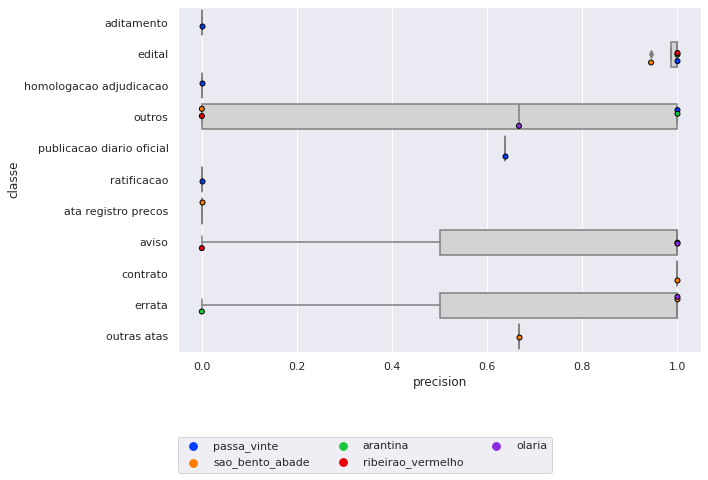

In [25]:
sns.set(rc={'figure.figsize':(10,7)})
metric = "precision"
sns.boxplot(x=metric, y="classe", color="#D3D3D3",
            #hue="city",# palette=["m", "g"],
            data=df_3)
sns.stripplot(x=metric, y="classe",data=df_3, palette="bright",
            hue="Avaliação", linewidth=1,edgecolor='black', jitter=0.3# dodge=True,
            )
#plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.legend(ncol=3,bbox_to_anchor=(0, -0.35), loc='lower left', borderaxespad=0.)
#plt.title("Precision das classes de documentos por município")
plt.tight_layout()

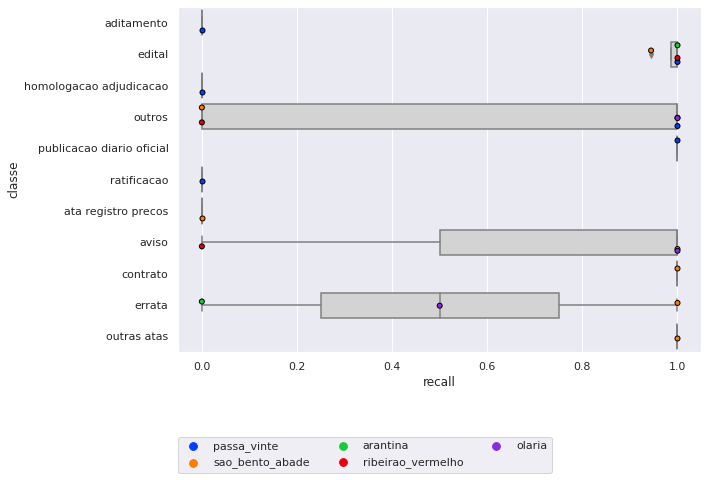

In [26]:
sns.set(rc={'figure.figsize':(10,7)})
metric = "recall"
sns.boxplot(x=metric, y="classe", color="#D3D3D3",
            #hue="city",# palette=["m", "g"],
            data=df_3)
sns.stripplot(x=metric, y="classe",data=df_3, palette="bright",
            hue="Avaliação", linewidth=1,edgecolor='black', jitter=0.3# dodge=True,
            )
#plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.legend(ncol=3,bbox_to_anchor=(0, -0.35), loc='lower left', borderaxespad=0.)
#plt.title("Recall das classes de documentos por município")
plt.tight_layout()

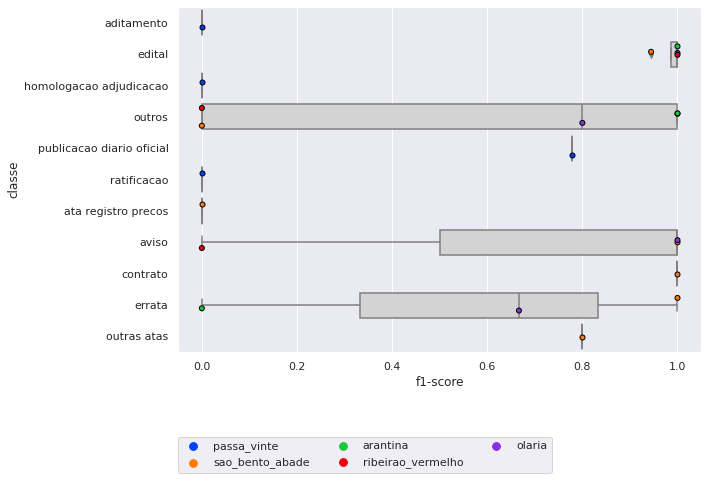

In [27]:
sns.set(rc={'figure.figsize':(10,7)})
metric = "f1-score"
sns.boxplot(x=metric, y="classe", color="#D3D3D3",
            #hue="city",# palette=["m", "g"],
            data=df_3)
sns.stripplot(x=metric, y="classe",data=df_3, palette="bright",
            hue="Avaliação", linewidth=1,edgecolor='black', jitter=0.3# dodge=True,
            )
#plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.legend(ncol=3,bbox_to_anchor=(0, -0.35), loc='lower left', borderaxespad=0.)
#plt.title("F1-score das classes de documentos por município")
plt.tight_layout()

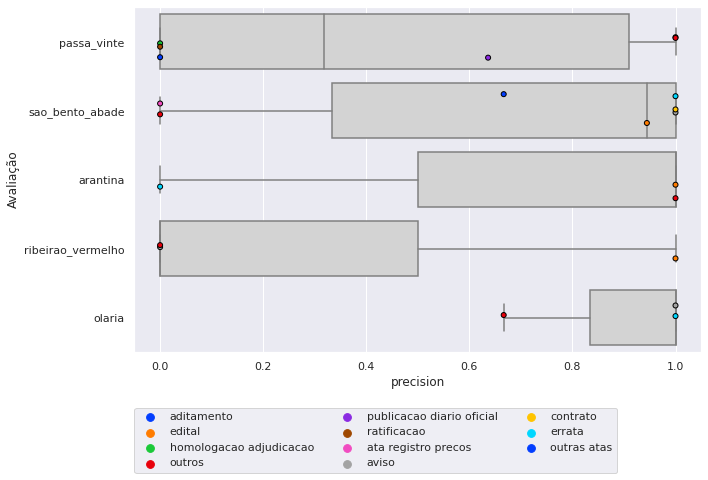

In [28]:
sns.set(rc={'figure.figsize':(10,7)})
metric = "precision"
sns.boxplot(x=metric, y="Avaliação", color="#D3D3D3",
            #hue="city",# palette=["m", "g"],
            data=df_3)
sns.stripplot(x=metric, y="Avaliação",data=df_3, palette="bright",
            hue="classe", linewidth=1,edgecolor='black', jitter=0.3# dodge=True,
            )
#plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.legend(ncol=3,bbox_to_anchor=(0, -0.35), loc='lower left', borderaxespad=0.)
plt.tight_layout()

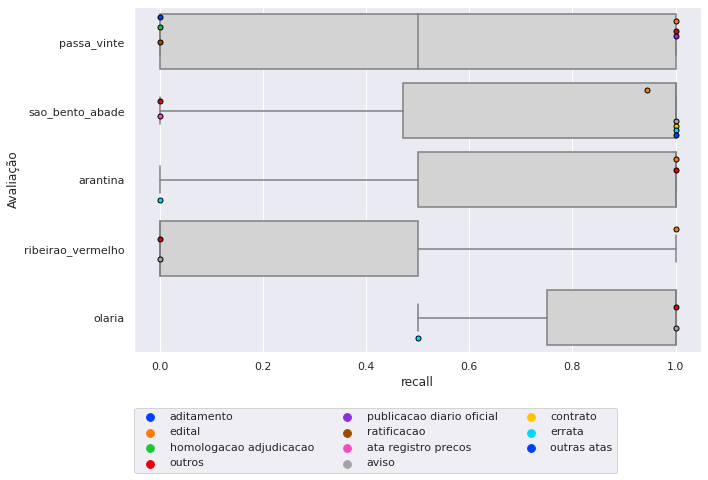

In [29]:
sns.set(rc={'figure.figsize':(10,7)})
metric = "recall"
sns.boxplot(x=metric, y="Avaliação", color="#D3D3D3",
            #hue="city",# palette=["m", "g"],
            data=df_3)
sns.stripplot(x=metric, y="Avaliação",data=df_3, palette="bright",
            hue="classe", linewidth=1,edgecolor='black', dodge=True,#jitter=0.3# dodge=True,
            )
#plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.legend(ncol=3,bbox_to_anchor=(0, -0.35), loc='lower left', borderaxespad=0.)
plt.tight_layout()

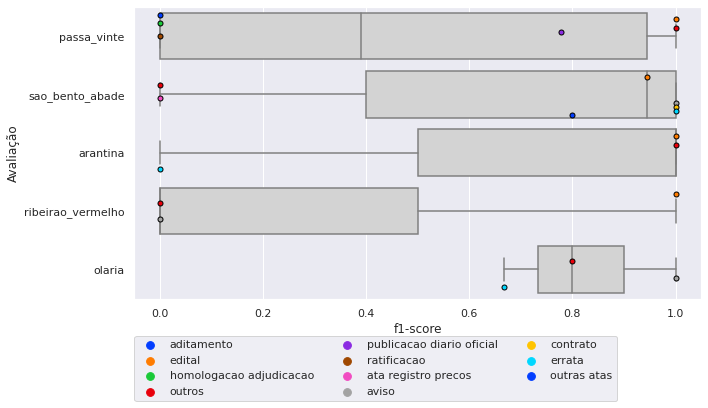

In [32]:
sns.set(rc={'figure.figsize':(10,6)})
metric = "f1-score"
sns.boxplot(x=metric, y="Avaliação", color="#D3D3D3",
            #hue="city",# palette=["m", "g"],
            data=df_3)
sns.stripplot(x=metric, y="Avaliação",data=df_3, palette="bright",
            hue="classe", linewidth=1,edgecolor='black', dodge=True#jitter=0.3# dodge=True,
            )
#plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.legend(ncol=3,bbox_to_anchor=(0, -0.35), loc='lower left', borderaxespad=0.)
#plt.title("F1-score para cada classe de documento por município")
plt.tight_layout()

In [31]:
df_2["classe"].unique()

array(['aditamento', 'aviso', 'edital', 'homologacao adjudicacao',
       'outras atas', 'outros', 'publicacao diario oficial',
       'ratificacao', 'accuracy', 'macro avg', 'weighted avg',
       'ata registro precos', 'contrato', 'errata',
       'ata dispensa licitacao', 'ata pregao presencial'], dtype=object)

# Distribuição Meta-classes por cidade

In [1]:
import pandas as pd

df = pd.read_csv("./lstm_data/preprocessed_data_v2.csv")
df.head()

,doc_id,final_meta-class,label,label_int,city,file_dir,one_page,two_pages,three_pages,four_pages,fold,four_pages_processed
0,499fa518c7724a6e449c509b7d7bc819,ATA,ata dispensa licitacao,0,cristais,../data/290-licitacoes-cristais/data/files_jso...,comissao permanente licitacoes ata dispensa ju...,comissao permanente licitacoes ata dispensa ju...,comissao permanente licitacoes ata dispensa ju...,comissao permanente licitacoes ata dispensa ju...,val,comissao permanente licitacoes ata dispensa ju...
1,56a09c5d1d04cc95ada4d68ad22dcbd9,ATA,ata dispensa licitacao,0,cristais,../data/290-licitacoes-cristais/data/files_jso...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,test,comissao permanente licitacoes dia fevereiro r...
2,6e9f35208290c1130fcccad47b50aa53,ATA,ata dispensa licitacao,0,cristais,../data/290-licitacoes-cristais/data/files_jso...,praca cel centro estado cep pabx cnpj comissa...,praca cel centro estado cep pabx cnpj comissa...,praca cel centro estado cep pabx cnpj comissa...,praca cel centro estado cep pabx cnpj comissa...,val,praca cel centro estado cep pabx cnpj comissao...
3,669c029c5812ec9a31b9c211044157b4,ATA,ata dispensa licitacao,0,cristais,../data/290-licitacoes-cristais/data/files_jso...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,val,comissao permanente licitacoes dia fevereiro r...
4,a22421dc45d623c9200c7e8fb1e6ca34,ATA,ata dispensa licitacao,0,cristais,../data/290-licitacoes-cristais/data/files_jso...,comissao permanente licitacoes maio reuniu com...,comissao permanente licitacoes maio reuniu com...,comissao permanente licitacoes maio reuniu com...,comissao permanente licitacoes maio reuniu com...,train,comissao permanente licitacoes maio reuniu com...


In [7]:
df.groupby(["city", "final_meta-class"]).size().reset_index(name="size").pivot_table(values="size", index="city", columns="final_meta-class").fillna(0).astype(int)

final_meta-class,ATA,EDITAL,HOMOLOG,OUTROS
city,,,,
arantina,0,283,0,45
coqueiral,295,299,0,887
cristais,356,575,2,354
ijaci,0,244,16,138
itamarati,1,261,232,101
olaria,0,1,0,27
passa_vinte,6,162,12,189
pirapetinga,67,101,114,484
ribeirao_vermelho,0,158,0,14


# Distribuição Cidade por fold

In [34]:
import pandas as pd
import numpy as np

df = pd.read_csv("./lstm_data/preprocessed_data_v2.csv")
df.head()

,doc_id,final_meta-class,label,label_int,city,file_dir,one_page,two_pages,three_pages,four_pages,fold,four_pages_processed
0,499fa518c7724a6e449c509b7d7bc819,ATA,ata dispensa licitacao,0,cristais,../data/290-licitacoes-cristais/data/files_jso...,comissao permanente licitacoes ata dispensa ju...,comissao permanente licitacoes ata dispensa ju...,comissao permanente licitacoes ata dispensa ju...,comissao permanente licitacoes ata dispensa ju...,val,comissao permanente licitacoes ata dispensa ju...
1,56a09c5d1d04cc95ada4d68ad22dcbd9,ATA,ata dispensa licitacao,0,cristais,../data/290-licitacoes-cristais/data/files_jso...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,test,comissao permanente licitacoes dia fevereiro r...
2,6e9f35208290c1130fcccad47b50aa53,ATA,ata dispensa licitacao,0,cristais,../data/290-licitacoes-cristais/data/files_jso...,praca cel centro estado cep pabx cnpj comissa...,praca cel centro estado cep pabx cnpj comissa...,praca cel centro estado cep pabx cnpj comissa...,praca cel centro estado cep pabx cnpj comissa...,val,praca cel centro estado cep pabx cnpj comissao...
3,669c029c5812ec9a31b9c211044157b4,ATA,ata dispensa licitacao,0,cristais,../data/290-licitacoes-cristais/data/files_jso...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,comissao permanente licitacoes dia fevereiro r...,val,comissao permanente licitacoes dia fevereiro r...
4,a22421dc45d623c9200c7e8fb1e6ca34,ATA,ata dispensa licitacao,0,cristais,../data/290-licitacoes-cristais/data/files_jso...,comissao permanente licitacoes maio reuniu com...,comissao permanente licitacoes maio reuniu com...,comissao permanente licitacoes maio reuniu com...,comissao permanente licitacoes maio reuniu com...,train,comissao permanente licitacoes maio reuniu com...


In [35]:
np.round((df.groupby(["city", "fold"]).size()/df.groupby(["city"]).size()*100).reset_index(name="size").pivot_table(values="size", index="city", columns="fold").fillna(0),2)[["train", "val","test"]]

fold,train,val,test
city,,,
arantina,67.99,22.26,9.76
coqueiral,68.74,21.34,9.93
cristais,70.78,19.11,10.10
ijaci,68.59,19.35,12.06
itamarati,69.92,20.00,10.08
olaria,53.57,21.43,25.00
passa_vinte,73.44,19.24,7.32
pirapetinga,71.15,19.06,9.79
ribeirao_vermelho,70.93,21.51,7.56


In [36]:
np.round((df.loc[df['city'].isin(['passa_vinte', 'sao_bento_abade', 'arantina', 'ijaci', 'ribeirao_vermelho', 'olaria'])].groupby(["city", "fold", "label"]).size()/df.loc[df['city'].isin(['passa_vinte', 'sao_bento_abade', 'arantina', 'ijaci', 'ribeirao_vermelho', 'olaria'])].groupby(["city", "label"]).size()*100).reset_index(name="size").pivot_table(values="size", index=["city", "fold"], columns="label").fillna(0),2).reset_index()

label,city,fold,aditamento,ata pregao presencial,ata registro precos,aviso,contrato,edital,errata,homologacao adjudicacao,outras atas,outros,publicacao diario oficial,ratificacao
0,arantina,test,0.00,0.00,0.00,0.00,0.00,9.89,50.00,0.00,0.00,6.98,0.00,0.00
1,arantina,train,0.00,0.00,0.00,0.00,0.00,66.43,50.00,0.00,0.00,79.07,0.00,0.00
2,arantina,val,0.00,0.00,0.00,0.00,0.00,23.67,0.00,0.00,0.00,13.95,0.00,0.00
3,ijaci,test,0.00,0.00,0.00,12.80,0.00,11.48,10.00,18.75,0.00,0.00,0.00,0.00
4,ijaci,train,0.00,0.00,0.00,68.80,0.00,68.85,50.00,68.75,0.00,100.00,0.00,100.00
5,ijaci,val,0.00,0.00,0.00,18.40,0.00,19.67,40.00,12.50,0.00,0.00,0.00,0.00
6,olaria,test,0.00,0.00,0.00,50.00,0.00,0.00,26.67,0.00,0.00,20.00,0.00,0.00
7,olaria,train,0.00,0.00,0.00,50.00,0.00,100.00,53.33,0.00,0.00,50.00,0.00,0.00
8,olaria,val,0.00,0.00,0.00,0.00,0.00,0.00,20.00,0.00,0.00,30.00,0.00,0.00
9,passa_vinte,test,11.11,0.00,0.00,0.00,0.00,6.79,0.00,16.67,0.00,7.58,6.80,9.09


In [37]:
np.round((df.groupby(["city", "fold", "label"]).size()/df.groupby(["city", "label"]).size()*100).reset_index(name="size").pivot_table(values="size", index=["city", "fold"], columns="label").fillna(0),2).reset_index()

label,city,fold,aditamento,ata dispensa licitacao,ata pregao presencial,ata registro precos,aviso,contrato,edital,errata,homologacao adjudicacao,outras atas,outros,publicacao diario oficial,ratificacao
0,arantina,test,0.00,0.00,0.00,0.00,0.00,0.00,9.89,50.00,0.00,0.00,6.98,0.00,0.00
1,arantina,train,0.00,0.00,0.00,0.00,0.00,0.00,66.43,50.00,0.00,0.00,79.07,0.00,0.00
2,arantina,val,0.00,0.00,0.00,0.00,0.00,0.00,23.67,0.00,0.00,0.00,13.95,0.00,0.00
3,coqueiral,test,8.49,0.00,0.00,10.85,4.00,9.59,11.37,5.88,0.00,16.22,8.44,0.00,33.33
4,coqueiral,train,68.87,0.00,0.00,66.67,68.00,70.15,67.56,73.53,0.00,70.27,68.83,0.00,66.67
5,coqueiral,val,22.64,0.00,0.00,22.48,28.00,20.26,21.07,20.59,0.00,13.51,22.73,0.00,0.00
6,cristais,test,0.00,9.94,11.36,10.34,0.00,0.00,9.57,4.17,0.00,0.00,10.93,13.75,0.00
7,cristais,train,0.00,70.17,67.42,79.31,100.00,0.00,72.17,79.17,100.00,71.43,70.04,62.50,0.00
8,cristais,val,0.00,19.89,21.21,10.34,0.00,0.00,18.26,16.67,0.00,28.57,19.03,23.75,0.00
9,ijaci,test,0.00,0.00,0.00,0.00,12.80,0.00,11.48,10.00,18.75,0.00,0.00,0.00,0.00


In [38]:
(df.groupby(["city", "fold", "label"]).size()).reset_index(name="size").pivot_table(values="size", index=["city", "fold"], columns="label").fillna(0).reset_index()

label,city,fold,aditamento,ata dispensa licitacao,ata pregao presencial,ata registro precos,aviso,contrato,edital,errata,homologacao adjudicacao,outras atas,outros,publicacao diario oficial,ratificacao
0,arantina,test,0.0,0.0,0.0,0.0,0.0,0.0,28.0,1.0,0.0,0.0,3.0,0.0,0.0
1,arantina,train,0.0,0.0,0.0,0.0,0.0,0.0,188.0,1.0,0.0,0.0,34.0,0.0,0.0
2,arantina,val,0.0,0.0,0.0,0.0,0.0,0.0,67.0,0.0,0.0,0.0,6.0,0.0,0.0
3,coqueiral,test,18.0,0.0,0.0,28.0,1.0,44.0,34.0,2.0,0.0,6.0,13.0,0.0,1.0
4,coqueiral,train,146.0,0.0,0.0,172.0,17.0,322.0,202.0,25.0,0.0,26.0,106.0,0.0,2.0
5,coqueiral,val,48.0,0.0,0.0,58.0,7.0,93.0,63.0,7.0,0.0,5.0,35.0,0.0,0.0
6,cristais,test,0.0,18.0,15.0,3.0,0.0,0.0,55.0,1.0,0.0,0.0,27.0,11.0,0.0
7,cristais,train,0.0,127.0,89.0,23.0,3.0,0.0,415.0,19.0,2.0,10.0,173.0,50.0,0.0
8,cristais,val,0.0,36.0,28.0,3.0,0.0,0.0,105.0,4.0,0.0,4.0,47.0,19.0,0.0
9,ijaci,test,0.0,0.0,0.0,0.0,16.0,0.0,28.0,1.0,3.0,0.0,0.0,0.0,0.0


In [39]:
df.loc[df["fold"]=='test'].groupby(["city", "fold", "label"]).size().reset_index(name='size')

,city,fold,label,size
0,arantina,test,edital,28
1,arantina,test,errata,1
2,arantina,test,outros,3
3,coqueiral,test,aditamento,18
4,coqueiral,test,ata registro precos,28
5,coqueiral,test,aviso,1
6,coqueiral,test,contrato,44
7,coqueiral,test,edital,34
8,coqueiral,test,errata,2
9,coqueiral,test,outras atas,6


In [40]:
np.round((df.loc[df['city'].isin(['passa_vinte', 'sao_bento_abade', 'arantina', 'ijaci', 'ribeirao_vermelho', 'olaria'])].groupby(["city", "fold", "label"]).size()).reset_index(name="size").pivot_table(values="size", index=["city", "fold"], columns="label").fillna(0),2).reset_index()

label,city,fold,aditamento,ata pregao presencial,ata registro precos,aviso,contrato,edital,errata,homologacao adjudicacao,outras atas,outros,publicacao diario oficial,ratificacao
0,arantina,test,0.0,0.0,0.0,0.0,0.0,28.0,1.0,0.0,0.0,3.0,0.0,0.0
1,arantina,train,0.0,0.0,0.0,0.0,0.0,188.0,1.0,0.0,0.0,34.0,0.0,0.0
2,arantina,val,0.0,0.0,0.0,0.0,0.0,67.0,0.0,0.0,0.0,6.0,0.0,0.0
3,ijaci,test,0.0,0.0,0.0,16.0,0.0,28.0,1.0,3.0,0.0,0.0,0.0,0.0
4,ijaci,train,0.0,0.0,0.0,86.0,0.0,168.0,5.0,11.0,0.0,2.0,0.0,1.0
5,ijaci,val,0.0,0.0,0.0,23.0,0.0,48.0,4.0,2.0,0.0,0.0,0.0,0.0
6,olaria,test,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0
7,olaria,train,0.0,0.0,0.0,1.0,0.0,1.0,8.0,0.0,0.0,5.0,0.0,0.0
8,olaria,val,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0
9,passa_vinte,test,1.0,0.0,0.0,0.0,0.0,11.0,0.0,2.0,0.0,5.0,7.0,1.0


In [41]:
from sklearn.model_selection import train_test_split
def split_data_by_city_and_class(df):
    # criamos uma nova classe cidade+label
    df["multi_label"] = df["label"]+"_"+df["city"]
    # verificamos se existem classes que aparecem apenas 1 vez em algum município
    df_multilabel_size = df.groupby("multi_label").size().reset_index(name="size")
    # selecionamos esses casos
    unique_classes = df_multilabel_size.loc[df_multilabel_size["size"]==1, 'multi_label'].values
    # definimos todos como treino
    df["fold"] = "train"
    # "classes unicas" vão pro conjunto de validação
    df.loc[(df["multi_label"].isin(unique_classes))& (df["fold"]=="train"), "fold"] = "val"

    num_docs = df.shape[0]
    test_size = round(0.1*num_docs)
    val_size = round(0.2*num_docs)

    # fazemos o split considerando a multi_label
    train, test, _, _ = train_test_split(
            df.loc[df["fold"] == "train"],
            df.loc[df["fold"] == "train","multi_label"], 
        stratify = df.loc[df["fold"] == "train","multi_label"],
        test_size = test_size, 
        random_state=SEED)
    # define os docs que vão pra validação
    df.loc[test.index, "fold"] = "test"

    # fazemos o split considerando a multi_label
    train, val, _, _ = train_test_split(
            df.loc[df["fold"] == "train"],
            df.loc[df["fold"] == "train","multi_label"], 
        stratify = df.loc[df["fold"] == "train","multi_label"],
        test_size = val_size, 
        random_state=SEED)
    # define os docs que vão pra validação
    df.loc[val.index, "fold"] = "val"
    
    return df

In [42]:
SEED = 42

In [43]:
df_data = split_data_by_city_and_class(df)

In [44]:
(df.groupby(["city", "fold", "label"]).size()).reset_index(name="size").pivot_table(values="size", index=["city", "fold"], columns="label").fillna(0).reset_index()

label,city,fold,aditamento,ata dispensa licitacao,ata pregao presencial,ata registro precos,aviso,contrato,edital,errata,homologacao adjudicacao,outras atas,outros,publicacao diario oficial,ratificacao
0,arantina,test,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,4.0,0.0,0.0
1,arantina,train,0.0,0.0,0.0,0.0,0.0,0.0,198.0,2.0,0.0,0.0,30.0,0.0,0.0
2,arantina,val,0.0,0.0,0.0,0.0,0.0,0.0,57.0,0.0,0.0,0.0,9.0,0.0,0.0
3,coqueiral,test,21.0,0.0,0.0,26.0,3.0,46.0,30.0,3.0,0.0,4.0,15.0,0.0,0.0
4,coqueiral,train,149.0,0.0,0.0,180.0,17.0,321.0,209.0,24.0,0.0,26.0,108.0,0.0,2.0
5,coqueiral,val,42.0,0.0,0.0,52.0,5.0,92.0,60.0,7.0,0.0,7.0,31.0,0.0,1.0
6,cristais,test,0.0,18.0,13.0,3.0,0.0,0.0,58.0,2.0,0.0,1.0,25.0,8.0,0.0
7,cristais,train,0.0,127.0,93.0,20.0,2.0,0.0,402.0,17.0,2.0,10.0,173.0,56.0,0.0
8,cristais,val,0.0,36.0,26.0,6.0,1.0,0.0,115.0,5.0,0.0,3.0,49.0,16.0,0.0
9,ijaci,test,0.0,0.0,0.0,0.0,13.0,0.0,24.0,1.0,2.0,0.0,0.0,0.0,0.0


In [45]:
df.groupby('city').size()

city
arantina              328
coqueiral            1481
cristais             1287
ijaci                 398
itamarati             595
olaria                 28
passa_vinte           369
pirapetinga           766
ribeirao_vermelho     172
sao_bento_abade       229
dtype: int64

In [47]:
np.round(df.groupby('city').size() / df.shape[0]*100,2)

city
arantina              5.80
coqueiral            26.20
cristais             22.77
ijaci                 7.04
itamarati            10.53
olaria                0.50
passa_vinte           6.53
pirapetinga          13.55
ribeirao_vermelho     3.04
sao_bento_abade       4.05
dtype: float64

In [50]:
from sklearn.metrics import classification_report

In [52]:
y_true = [0]*10275
y_true.extend([1]*91)

y_pred = [0]*10270
y_pred.extend([1]*5)
y_pred.extend([0]*56)
y_pred.extend([1]*35)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     10275
           1       0.88      0.38      0.53        91

    accuracy                           0.99     10366
   macro avg       0.93      0.69      0.77     10366
weighted avg       0.99      0.99      0.99     10366

